<a href="https://colab.research.google.com/github/Serghei-S/investigation-of-the-effectiveness-of-boosting-and-bagging-models/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Тема: **Исследование эффективности ансамблевых моделей на примере задачи регрессии на реальных данных.**

Целью курсовой работы является: **проведение эмпирического исследования эффективности применения различных ансамблевых моделей для решения задачи регрессии на основе реальных данных и формулировка рекомендаций по выбору оптимального метода.**

Задачи работы:

1. Провести обзор  по теоретическим основам ансамблевых методов (bagging, boosting, stacking).


2. Подобрать и описать реальный датасет для регрессионного анализа; выполнить его предварительную обработку и исследовательский анализ признаков.

3. Реализовать ансамблевые модели:
* Случайный лес (Random Forest,Extra Trees )

* Градиентные  бустинги (CatBoost, XGBoost/LightGBM и тд)

* Адаптивный бустинг (AdaBoost)

* Метод стекинга (stacking)

4. Оценить качество построенных моделей по ключевым  метрикам и времени обучения. Проверить устойчивость результатов с помощью кросс-валидации и кривых обучения.

5. Сравнить результаты ансамблевых моделей с базовыми одиночными алгоритмами (линейная регрессия, решающие деревья и тд), нейросетевыми моделями и выявить наиболее эффективный подход.

# 1. Чтение даные и преобрзование атрибутов

In [ ]:
df1 = pd.read_csv('data_stock.csv')

In [ ]:
df = df1.drop('hour',axis = 1)

In [ ]:
df

,minute,traf,temp,damp
0,2013-09-01 00:00:01,0,14,0
1,2013-09-01 01:05:01,0,14,0
2,2013-09-01 02:05:01,0,14,0
3,2013-09-01 03:00:01,0,13,0
4,2013-09-01 04:05:01,0,13,0
...,...,...,...,...
19280,2015-12-01 10:36:00,5,0,0
19281,2015-12-01 11:36:00,4,0,0
19282,2015-12-01 12:36:00,4,1,0
19283,2015-12-01 13:36:00,4,1,0


Я взял датасет, описывающий транспортное состояние района ВДНХ за 2013-2015 год.Целевая переменная - 'traf', принимает значения от 0 до 10(загруженность дорог в данный момент).

Проведем преобразование столбца minute,чтобы сделать его пригодным для дальнейшего построения моделей

In [ ]:
df['minute'] = pd.to_datetime(df['minute'])
df['day_of_week'] = df['minute'].dt.dayofweek + 1  # 1-7 (1=понедельник)
#df['day_of_month'] = df['minute'].dt.day           # 1-31
df['month'] = df['minute'].dt.month                # 1-12
df['year'] = df['minute'].dt.year                  # например, 2013
df['hour'] = df['minute'].dt.hour           # 0-23
#df['day_of_week_name'] = df['minute'].dt.day_name()
df['year'] = df['year'].astype('category')
df['month'] = df['month'].astype('category')
df['day_of_week'] = df['day_of_week'].astype('category')
df['minute'] = pd.to_datetime(df['minute'])
df['minute1'] = df['minute'].dt.minute

In [ ]:
df = df.drop('minute',axis = 1)

In [ ]:
df

,traf,temp,damp,day_of_week,month,year,hour,minute1
0,0,14,0,7,9,2013,0,0
1,0,14,0,7,9,2013,1,5
2,0,14,0,7,9,2013,2,5
3,0,13,0,7,9,2013,3,0
4,0,13,0,7,9,2013,4,5
...,...,...,...,...,...,...,...,...
19280,5,0,0,2,12,2015,10,36
19281,4,0,0,2,12,2015,11,36
19282,4,1,0,2,12,2015,12,36
19283,4,1,0,2,12,2015,13,36


In [ ]:
df.describe()

,traf,temp,damp,hour,minute1
count,19285.000000,19285.000000,19285.000000,19285.000000,19285.000000
mean,2.155821,7.156391,1.337361,11.277418,3.640809
std,2.451825,9.889113,9.413767,6.801524,6.846219
min,0.000000,-25.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,5.000000,0.000000
50%,1.000000,6.000000,0.000000,11.000000,0.000000
75%,5.000000,14.000000,0.000000,17.000000,5.000000
max,10.000000,33.000000,127.000000,23.000000,53.000000


Опишем каждый столбцец нашего датасета:
1. traf - принмает значения от 0 до 10
2. temp(температура в градусах цельсия) - от 0 до 33
3. damp(влажность в граммах/$метр^3$) - от 0 до 127
4. hour - час принимает значения от 0 до 23
5. minute - от 0 до 53
6. year - дискретная величина, три года: 2013,2014,2015
7. day_of_week - принимает значения от 1 до 7, соотвественно 1 - Понедельник, 7 - Воскресенье
8. month - месяц, значения от 1 до 12, 1 - Январь, 12 - Декабрь

In [ ]:
X = df.drop('traf', axis=1)
y = df['traf']

In [ ]:
pd.DataFrame(df.dtypes, columns=['Тип данных'])

,Тип данных
traf,int64
temp,int64
damp,int64
day_of_week,category
month,category
year,category
hour,int32
minute1,int32


# 2. EDA

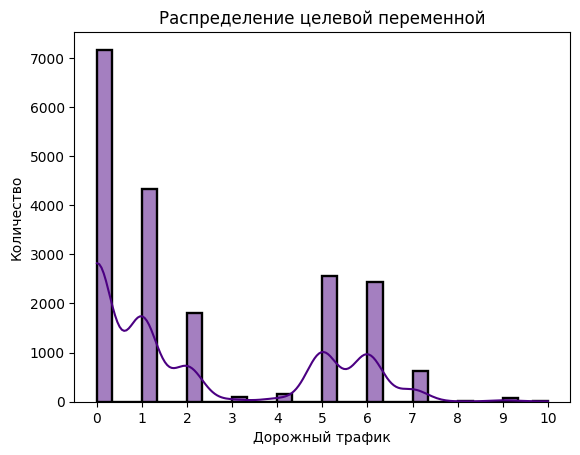

In [ ]:
plt.figure()
sns.histplot(df['traf'],
             kde=True,
             bins=30,
             color='#4B0082',
             edgecolor='black', linewidth=1.7)

plt.title("Распределение целевой переменной")
plt.xlabel("Дорожный трафик")
plt.ylabel("Количество")
plt.xticks(np.arange(0, 11, 1))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y):d}'))
plt.show()

По распредлению целевой переменной у нас виден сильный сильный дисбаланс классов, если бы расмаатривали многоклассовую классификацию.

Наши 11 уникальных значений дискретны, но они упорядочены и имеют смысл «чем больше — тем выше трафик». Порядок и метрика между значениями важны ⇒ регрессия сохраняет информацию, классификация её потеряет.

 Также Регрессионная модель может аппроксимировать через одну функцию, классификация заставит вас «нарезать» фиксированные бины, но если мы бы объединили условно '5' и '6' в один класс, то потеряли мы информативность модели.

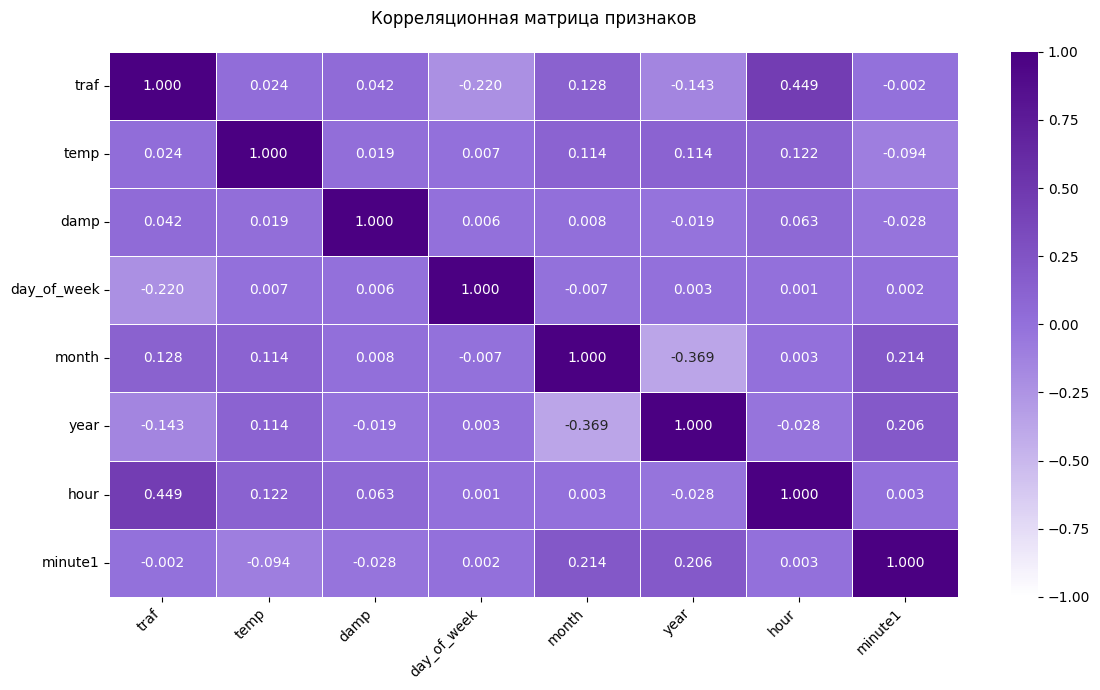

In [ ]:
corr = df.corr()
colors = ['#ffffff', '#9370DB', '#4B0082']
my_cmap = LinearSegmentedColormap.from_list("my_palette", colors)
plt.figure(figsize=(11.9, 7))
sns.heatmap(
    corr,
    annot=True,
    cmap=my_cmap,
    linewidths=0.5,
    vmin=-1,
    vmax=1,
    center=0,
    fmt=".3f"
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Корреляционная матрица признаков', pad=20)
plt.tight_layout()
plt.show()

По корреляционной матрице мы видим отсутсвие мультиколлиниарности в данных. Также маленькое значения частных коэффициентов корреляции показывает, что линейая взаимосвязь в переменных отсуствует и нам придется исползовать сложные модели для поиска нелинейных связей.

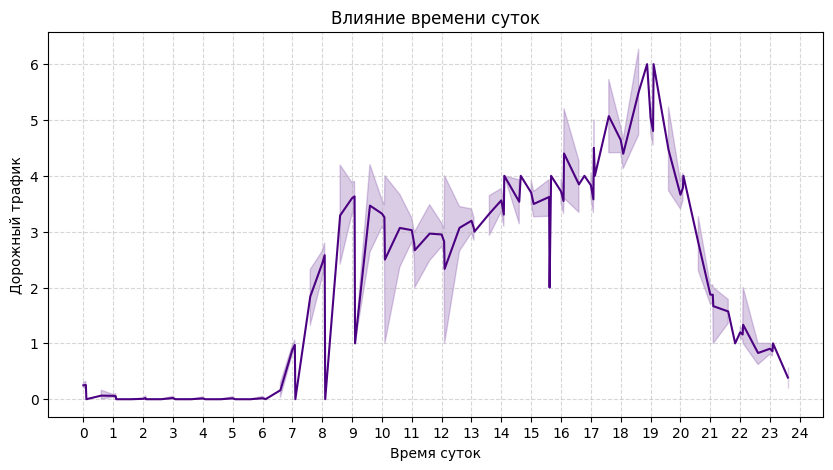

In [ ]:
X['time_of_day'] = X['hour'] + X['minute1']/60
plt.figure(figsize=(10, 5))
sns.lineplot(x=X['time_of_day'], y=y, color='#4B0082', linewidth=1.5)
plt.title('Влияние времени суток')
plt.xlabel('Время суток')
plt.ylabel('Дорожный трафик')
plt.xticks(range(0,25,1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

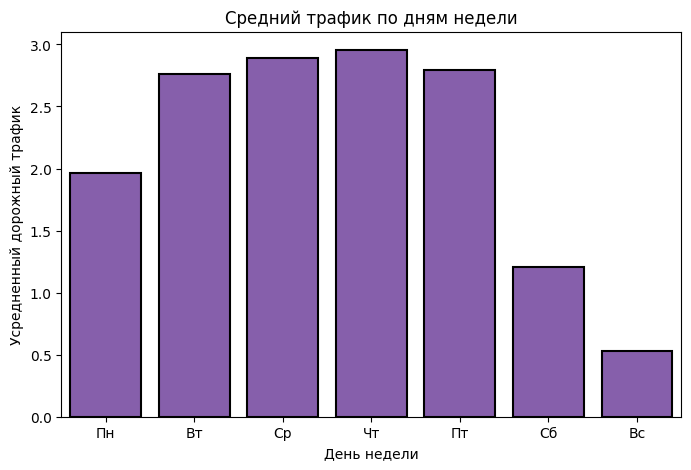

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(x=df['day_of_week'], y=y, color='#8752B8', edgecolor='black', linewidth=1.5,errorbar=None)
plt.title('Средний трафик по дням недели')
plt.xlabel('День недели')
plt.ylabel('Усредненный дорожный трафик')
plt.xticks(ticks=range(7), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

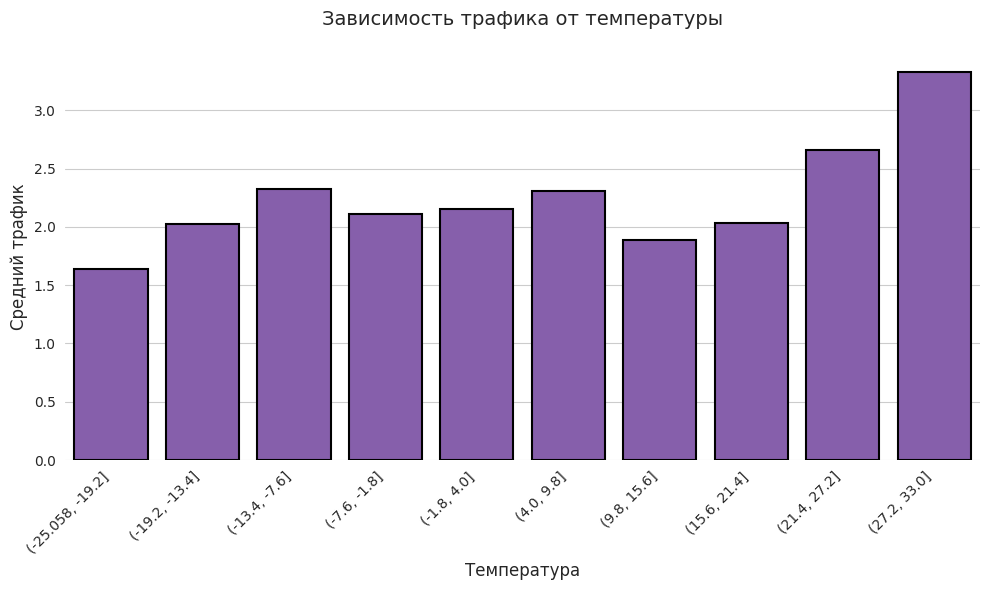

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
temp_bins = pd.cut(df['temp'], bins=10)
plot = sns.barplot(
        x=temp_bins,
        y=y,
        color='#8752B8',
        edgecolor='black',
        linewidth=1.5,
        errorbar=None
    )
plt.title('Зависимость трафика от температуры', pad=20, fontsize=14)
plt.xlabel('Температура', fontsize=12)
plt.ylabel('Средний трафик', fontsize=12)
plt.xticks(rotation=45, ha='right')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

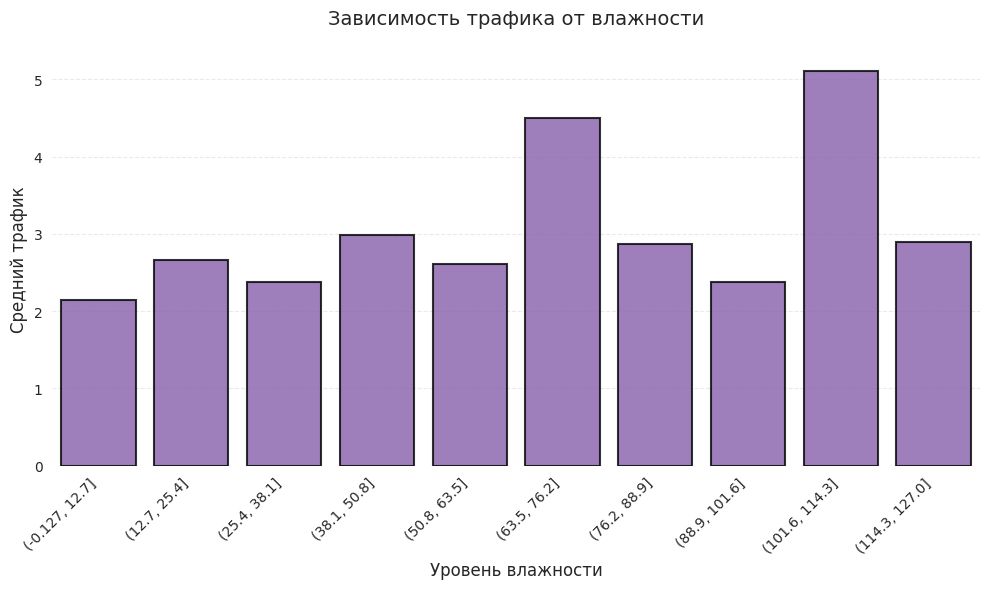

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
damp_bins = pd.cut(df['damp'], bins=10)
sns.barplot(
    x=damp_bins,
    y=y,
    color='#8752B8',
    edgecolor='black',
    linewidth=1.5,
    errorbar=None,
    alpha=0.8
)
plt.title('Зависимость трафика от влажности', pad=20, fontsize=14)
plt.xlabel('Уровень влажности', fontsize=12)
plt.ylabel('Средний трафик', fontsize=12)
plt.xticks(rotation=45, ha='right')
sns.despine(left=True, bottom=True)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

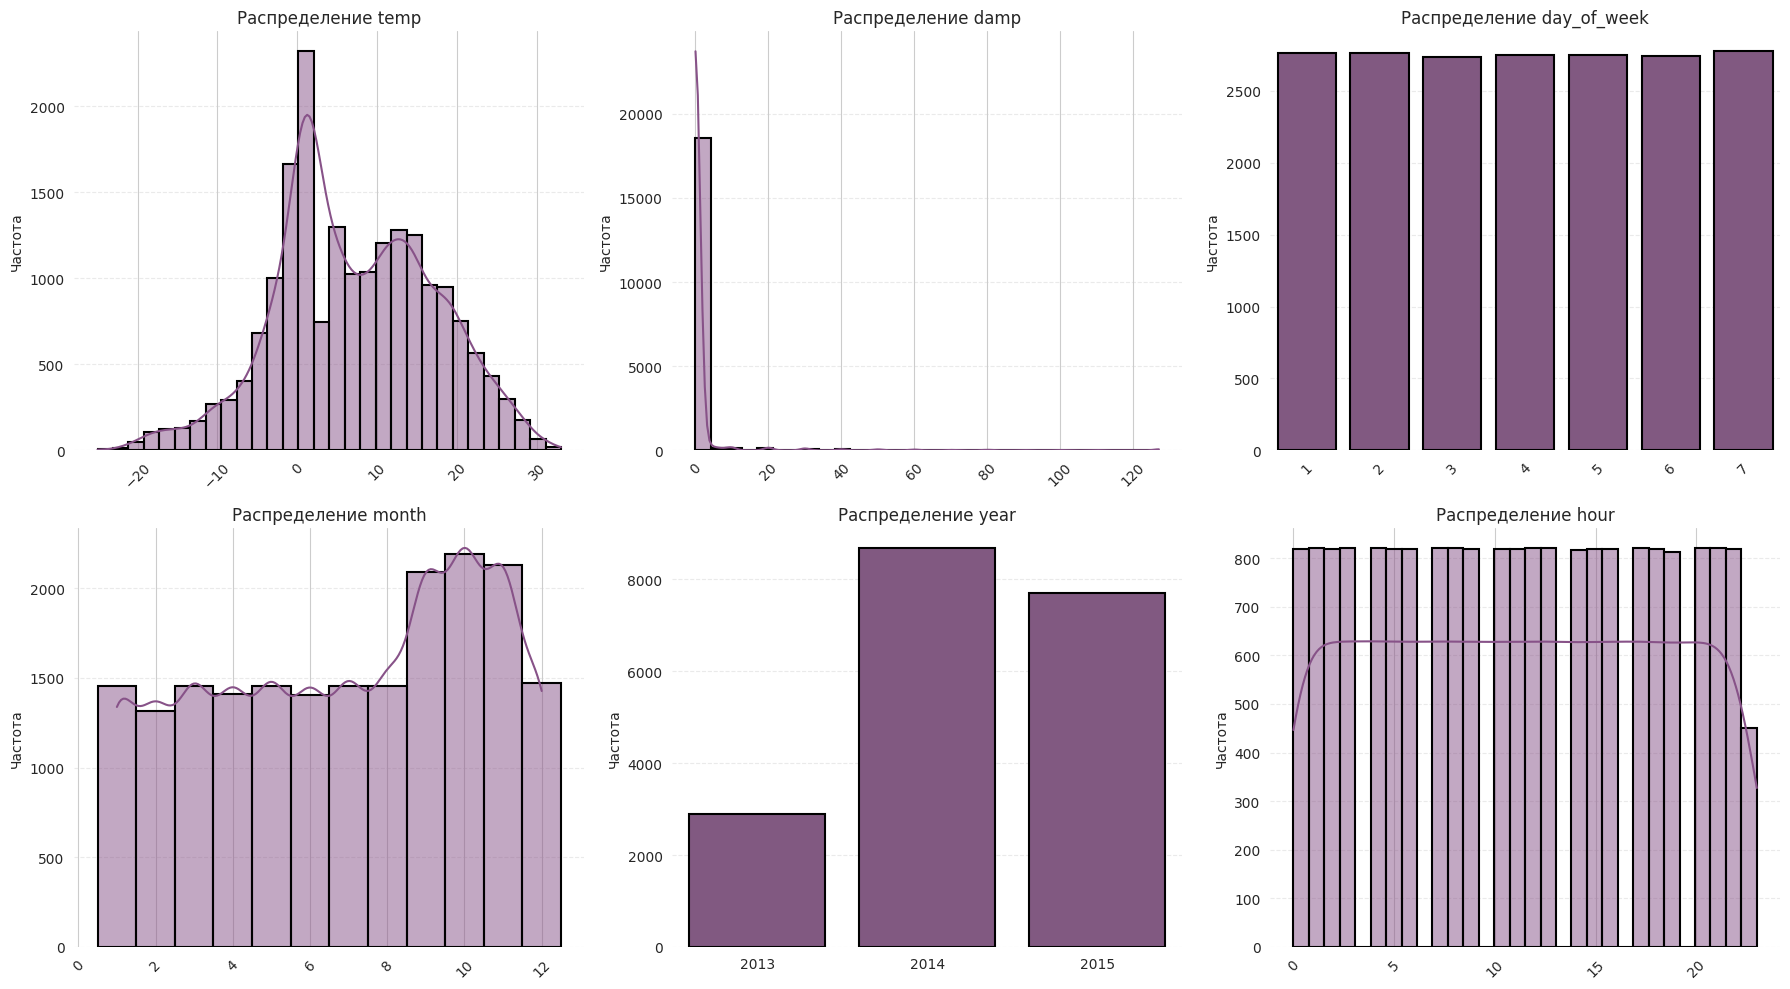

In [ ]:
available_features = ['temp', 'damp', 'day_of_week', 'month', 'year', 'hour', 'minute', 'time_of_day']
features_to_plot = [f for f in available_features if f in df.columns]
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
colors = ['#875288', '#9370DB', '#4B0082']

n_cols = 3
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols  # Округление вверх
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    # Для категориальных признаков
    if df[feature].dtype == 'object' or df[feature].nunique() < 10:
        sns.countplot(
            x=df[feature],
            ax=ax,
            color=colors[0],
            edgecolor='black',
            linewidth=1.5
        )
    # Для числовых признаков
    else:
        sns.histplot(
            df[feature],
            ax=ax,
            color=colors[0],
            edgecolor='black',
            linewidth=1.5,
            kde=True,
            bins=30
        )
    ax.set_title(f'Распределение {feature}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Частота' if df[feature].dtype != 'object' else 'Количество')
    sns.despine(ax=ax, left=True, bottom=True)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    if len(df[feature].unique()) > 5:
        ax.tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Давайте опишем распределение каждого столбца:

1. Распределение temp (температура):

Это распределение выглядит бимодальным (имеет два пика).

Первый, более выраженный пик, находится в районе 0-5 градусов Цельсия.

Второй пик, чуть менее выраженный, располагается в районе 10-15 градусов Цельсия.

Между пиками наблюдается спад частоты.

Диапазон температур простирается примерно от -25°C до +30°C.

Распределение имеет некоторую правостороннюю асимметрию (хвост уходит вправо).

2. Распределение damp (вероятно, влажность или какой-то показатель затухания):

Это распределение сильно скошено вправо (положительная асимметрия).

Подавляющее большинство значений сконцентрировано около нуля (или очень низких значений).

Частота резко падает для более высоких значений этого показателя. Есть небольшое количество значений, простирающихся до 120, но они очень редки.

3. Распределение day_of_week (день недели):

Это распределение выглядит практически равномерным.

Каждый день недели (представленный числами от 1 до 7) имеет примерно одинаковую частоту.

Это говорит о том, что данные собирались или события происходили с одинаковой интенсивностью в разные дни недели.

4. Распределение month (месяц):

Распределение по месяцам неравномерное.

Наблюдается тенденция к увеличению частоты в осенние месяцы (сентябрь, октябрь, ноябрь – пики), с последующим некоторым снижением к декабрю.

Зимние и весенние месяцы (1-8) имеют меньшую, но относительно стабильную частоту, с небольшим подъемом к летним месяцам, а затем более выраженным ростом к осени.

5. Распределение year (год):

Распределение по годам показывает, что наибольшее количество наблюдений приходится на 2014 год.

В 2013 году наблюдений меньше всего.

В 2015 году количество наблюдений несколько меньше, чем в 2014, но значительно больше, чем в 2013.

6. Распределение hour (час):

Распределение по часам в основном равномерное для большей части суток (примерно с 0 до 21-22 часов).

Наблюдается заметное снижение частоты в самые последние часы (вероятно, 22-23 часа, судя по спаду на правом краю гистограммы и кривой плотности).

Это может указывать на меньшую активность или сбор данных в ночные часы перед полуночью.

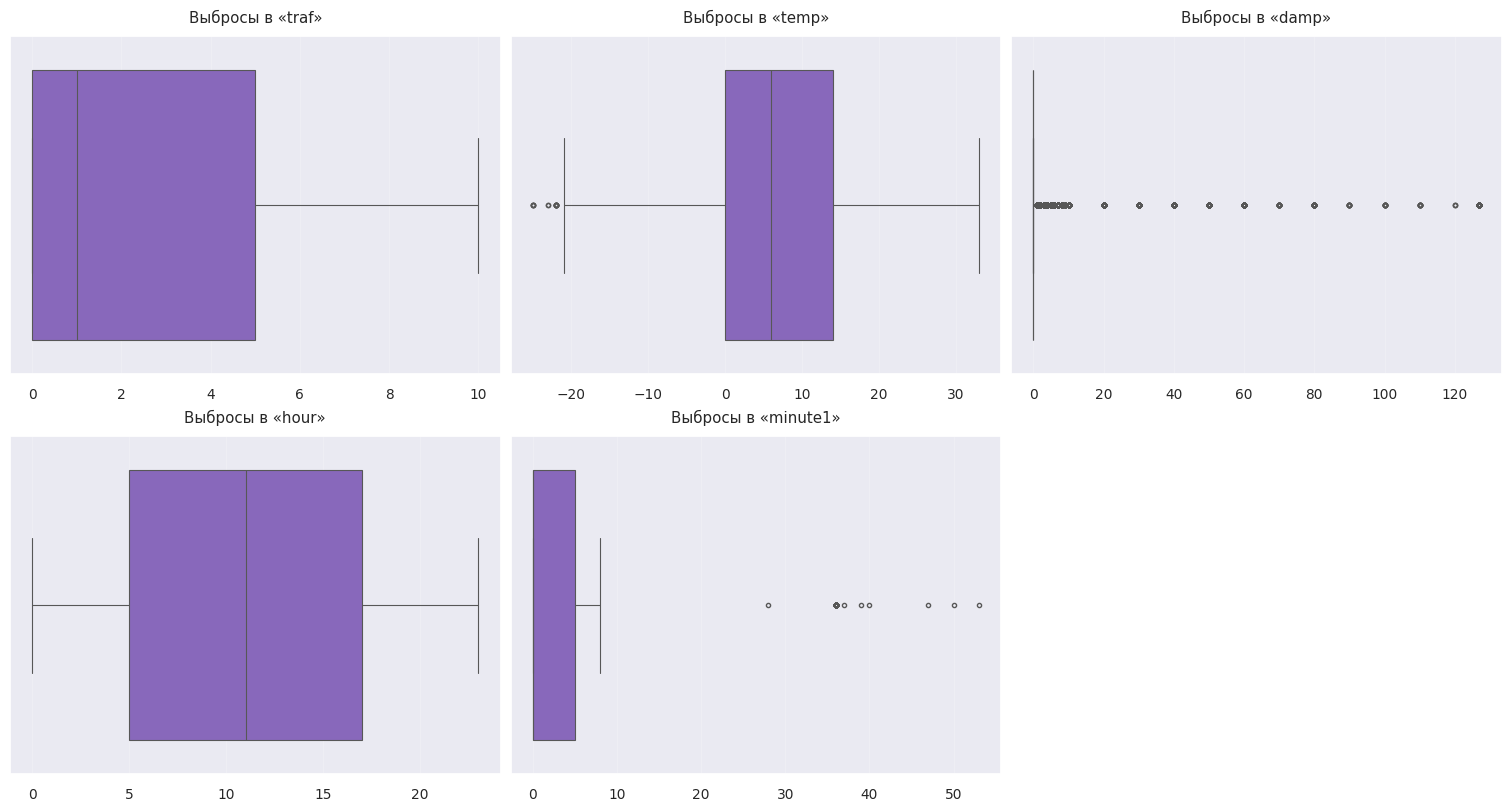

In [ ]:
num_cols = df.select_dtypes(include=["int", "float"]).columns.tolist()
my_cmap = LinearSegmentedColormap.from_list("my_palette",["#ffffff", "#9370DB", "#4B0082"])
plt.style.use("default")
sns.set(font_scale=0.9)
sns.set_palette([my_cmap(0.7)])
n_cols = 3
n_rows = -(-len(num_cols) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(5 * n_cols, 4 * n_rows),
                         constrained_layout=True)
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
for i, col in enumerate(num_cols):
    sns.boxplot(
        x=df[col],
        ax=axes[i],
        color=my_cmap(0.6),
        fliersize=3,
        linewidth=0.8
    )
    axes[i].set_title(f"Выбросы в «{col}»", pad=10)
    axes[i].set_xlabel("")
    axes[i].grid(axis="x", alpha=0.2)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.show()

Не будем убирать выбросы, так как они содержат в себе информацию и являются вполне логичными, например, температура может быть отрицательной и при экстремальных морозах транспортная ситуация на дорогах может меняться.

# 3. Обучим основные 'слабые' модели

In [ ]:
categorical_cols = ['day_of_week', 'month']
X[categorical_cols] = X[categorical_cols].astype('category')
#One-Hot Encoding для категориальных признаков
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
models = {
    "Bayesian Ridge": BayesianRidge(),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.7),
    "Lasso Regression": Lasso(alpha=0.1),
    "Ridge Regression": Ridge(alpha=0.1),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42, max_depth=5),
    "KNN"        : KNeighborsRegressor(n_neighbors=5),
    #" SVR (Linear) C = 1": SVR(kernel='linear', C=1.0, epsilon=0.1),
    #"SVR (Linear) C = 10": SVR(kernel='linear', C=10.0, epsilon=0.1)
}
results1   = []
exec_time1 = []
for name, model in models.items():
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    t1 = time.perf_counter()
    exec_time1.append(round(t1 - t0, 4))
    mae   = mean_absolute_error(y_test, y_pred)
    mse   = mean_squared_error(y_test, y_pred)
    rmse  = np.sqrt(mse)
    r2    = r2_score(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)

    # значения ≤ 0 убираем (MSLE не принимает  нули и отрицательные значения)
    y_test_safe = np.maximum(0, y_test)
    y_pred_safe = np.maximum(0, y_pred)
    msle = mean_squared_log_error(y_test_safe, y_pred_safe)

    results1.append({
        "Model" : name,
        "MAE"   : round(mae, 3),
        "MSE"   : round(mse, 3),
        "RMSE"  : round(rmse, 3),
        "R2"    : round(r2, 3),
        "MedAE" : round(medae, 3),
        "MSLE"  : round(msle, 3) if not np.isnan(msle) else None,
        "Time"  : exec_time1[-1]
    })

In [ ]:
results_df = pd.DataFrame(results1)
print("Результаты оценки моделей:")
results_df

Результаты оценки моделей:


,Model,MAE,MSE,RMSE,R2,MedAE,MSLE,Time
0,Bayesian Ridge,1.623,3.746,1.935,0.378,1.541,0.401,0.0187
1,ElasticNet,1.719,4.173,2.043,0.307,1.483,0.424,0.0788
2,Lasso Regression,1.727,4.200,2.049,0.303,1.479,0.427,0.0143
3,Ridge Regression,1.623,3.746,1.936,0.378,1.540,0.402,0.1195
4,Linear Regression,1.623,3.746,1.936,0.378,1.540,0.402,0.1189
5,Decision Tree,0.978,2.258,1.503,0.625,0.586,0.187,0.0266
6,KNN,1.007,2.287,1.512,0.620,0.600,0.211,0.3577


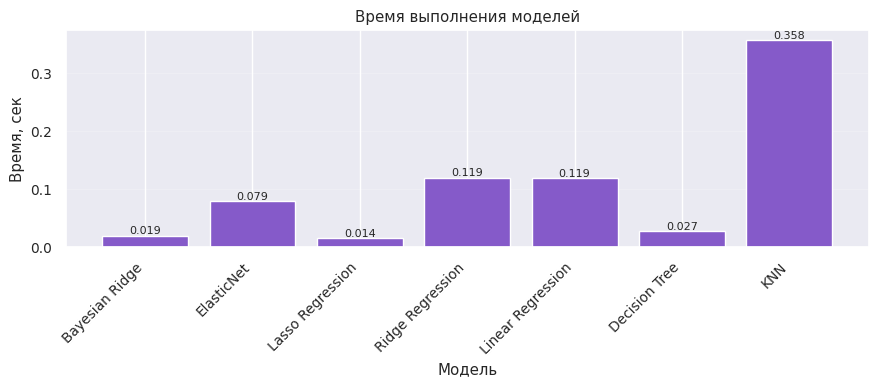

In [ ]:
my_cmap = LinearSegmentedColormap.from_list("my_palette",
                                            ["#ffffff", "#9370DB", "#4B0082"])

plt.figure(figsize=(9, 4))
bars = plt.bar(results_df["Model"], results_df["Time"],
               color=[my_cmap(0.6)]*len(results_df))
plt.title("Время выполнения моделей")
plt.xlabel("Модель")
plt.ylabel("Время, сек")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)

for bar, t in zip(bars, exec_time1):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{t:.3f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

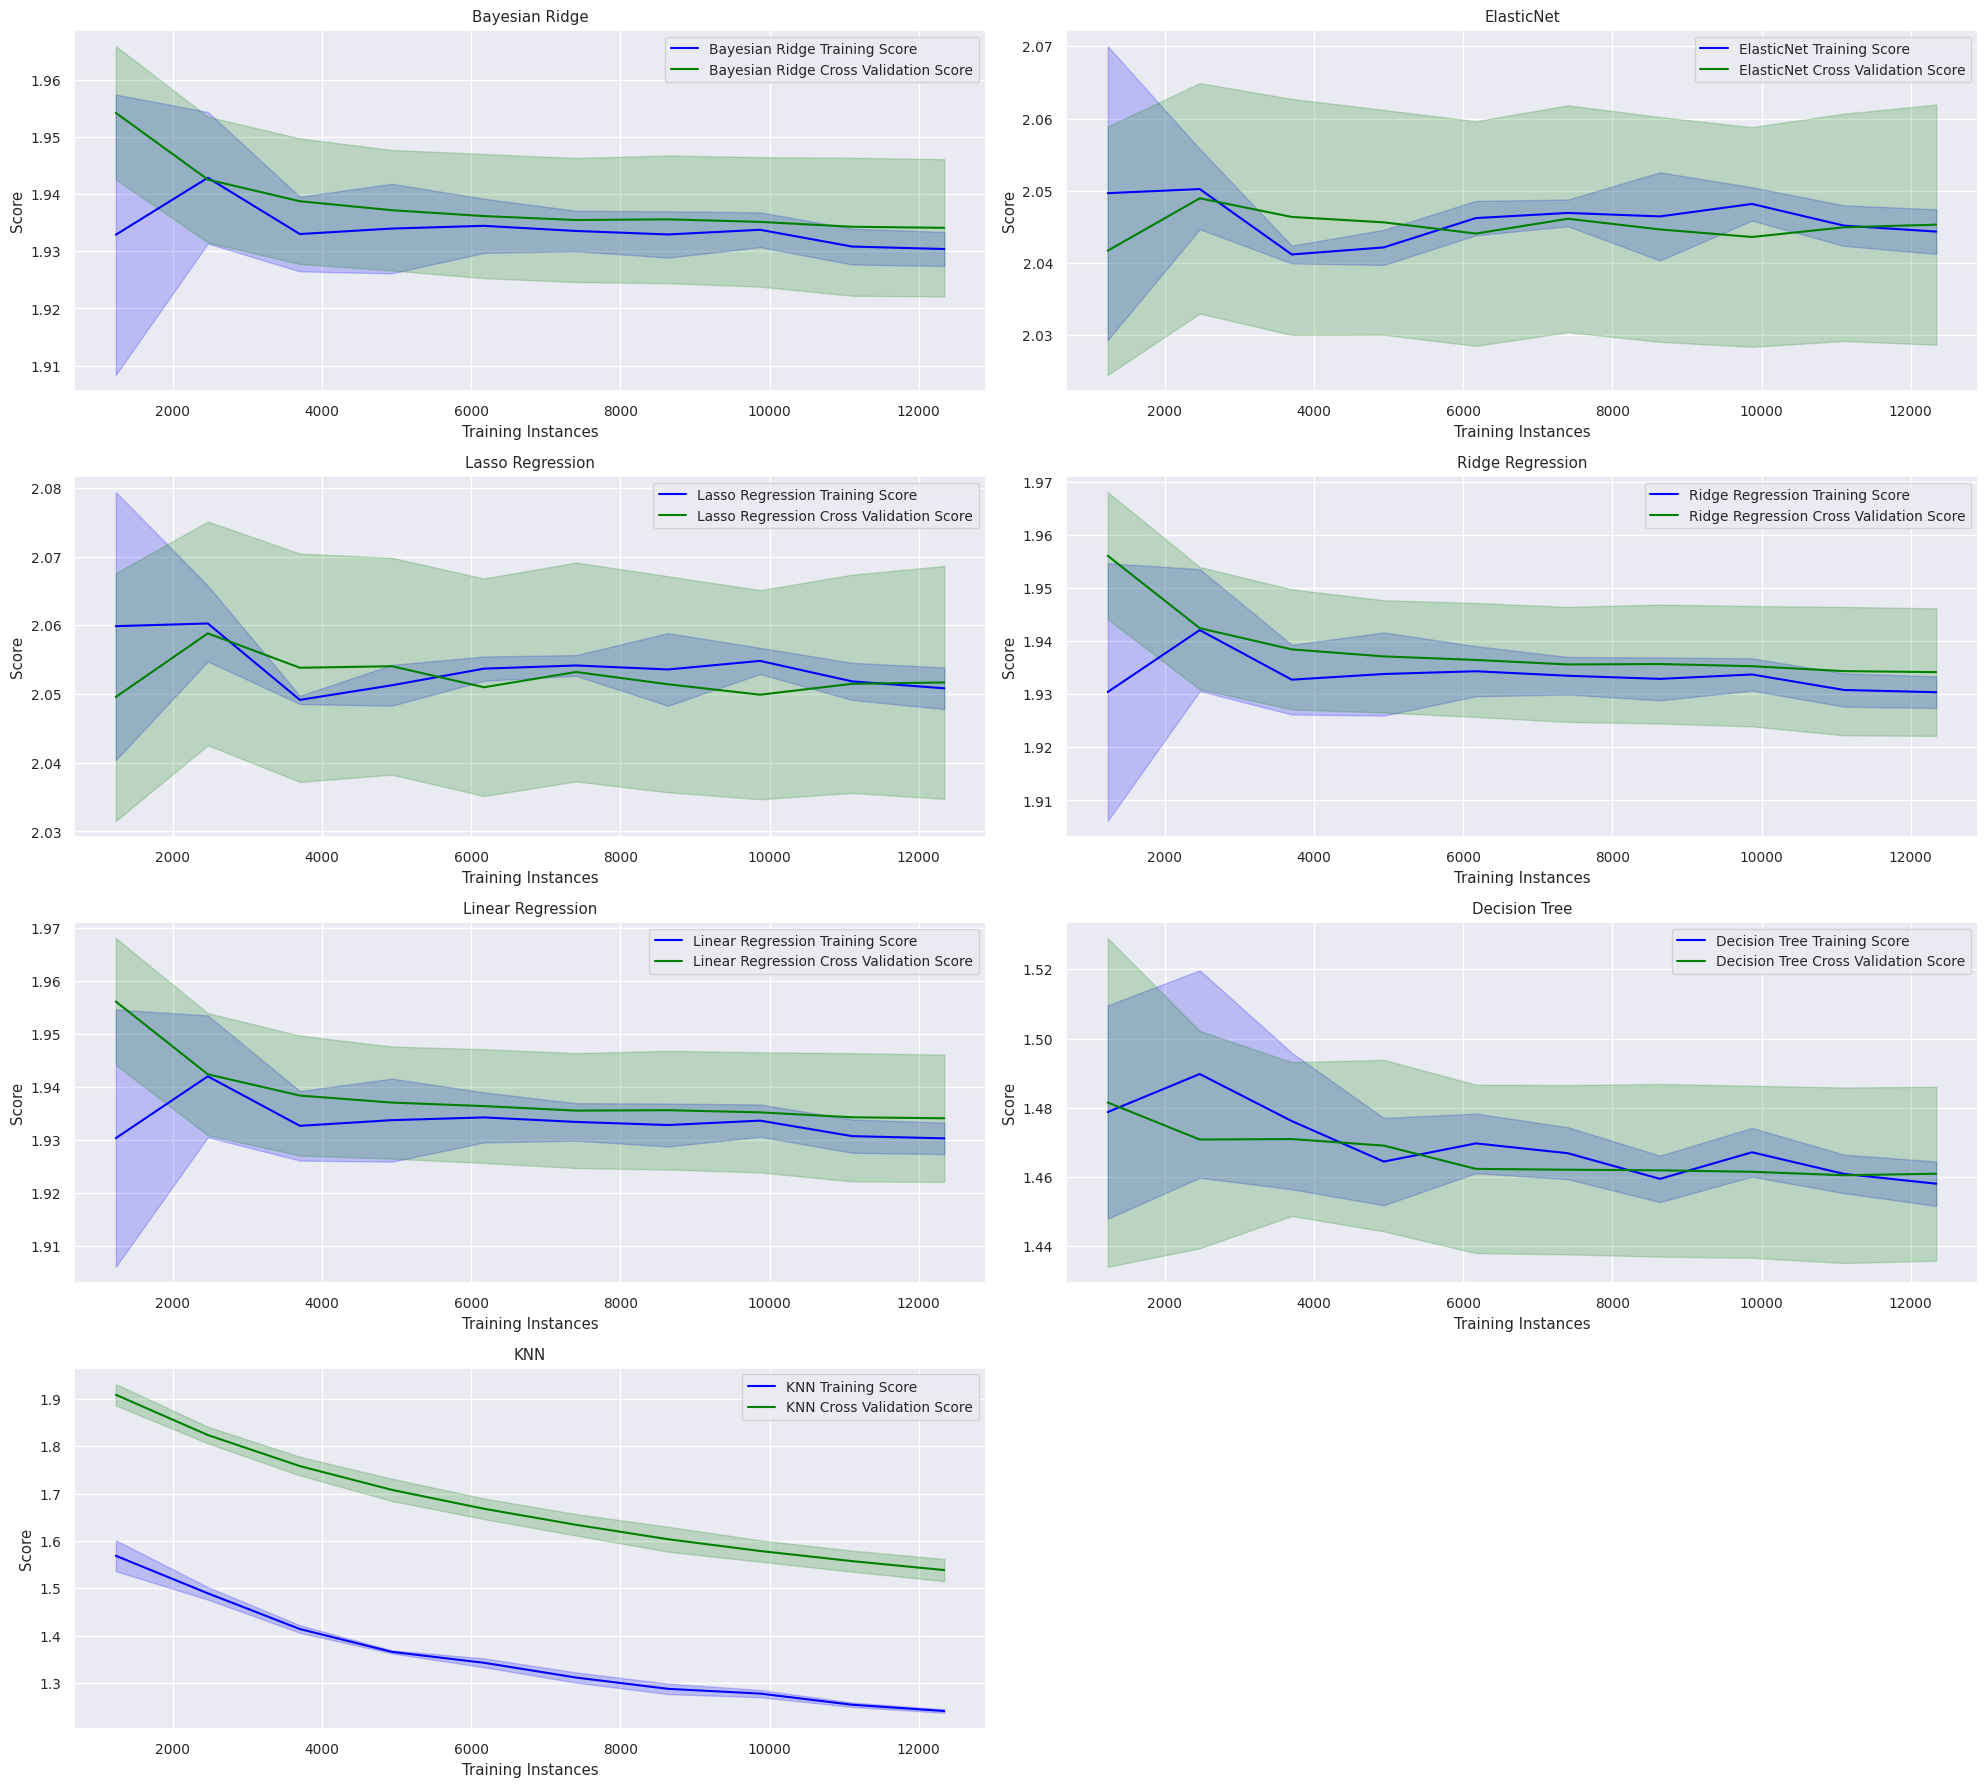

In [ ]:
plt.figure(figsize=(20, 18))
for i, (name, model) in enumerate(models.items()):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1,
                                                            train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_root_mean_squared_error')

    train_mean = -train_scores.mean(axis=1)
    test_mean = -test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)

    plt.subplot(4, 2, i+1)
    plt.plot(train_sizes, train_mean, label=f'{name} Training Score', color='blue')
    plt.plot(train_sizes, test_mean, label=f'{name} Cross Validation Score', color='green')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

    plt.title(f'{name}')
    plt.xlabel('Training Instances')
    plt.ylabel('Score')
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

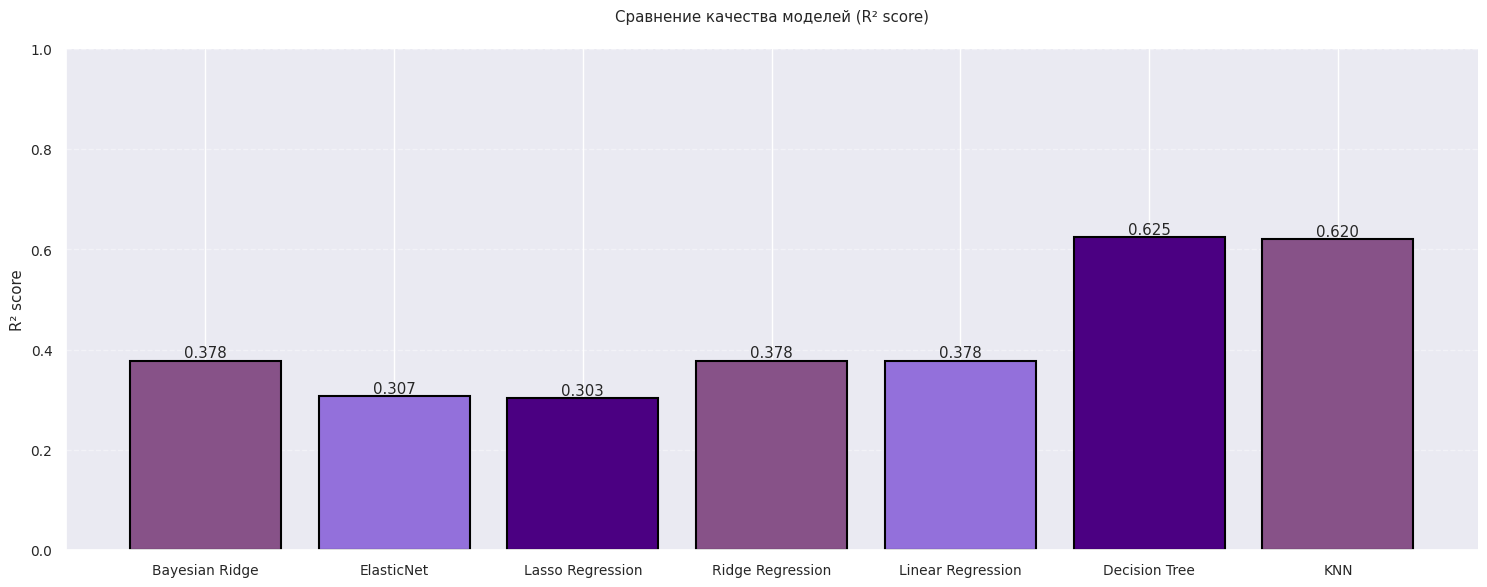

In [ ]:
plt.figure(figsize=(15, 6))
models_names = results_df['Model'].values
r2_scores = results_df['R2'].values

bars = plt.bar(models_names, r2_scores, color=['#875288', '#9370DB', '#4B0082'],
               edgecolor='black', linewidth=1.5)

plt.title('Сравнение качества моделей (R² score)', pad=20)
plt.ylabel('R² score')
plt.ylim(0, 1)
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.4)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

Мы видим, что линейные модели показли себя крайне плохо.Дерево решение и KNN показли чуть лучший резаультат. Попробуем нормализровать данные, так как это критично в случае KNN и Метода Опорных веткоров

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
base_models = {
    "Bayesian Ridge"   : BayesianRidge(),
    "ElasticNet"       : ElasticNet(alpha=0.1, l1_ratio=0.7),
    "Lasso Regression" : Lasso(alpha=0.1),
    "Ridge Regression" : Ridge(alpha=0.1),
    "Linear Regression": LinearRegression(),
    "Decision Tree"    : DecisionTreeRegressor(random_state=42, max_depth=5),
    "KNN"              : KNeighborsRegressor(n_neighbors=5),
    "SVR (Linear) C = 1": SVR(kernel='linear', C=1.0, epsilon=0.1),
    "SVR (Linear) C = 10": SVR(kernel='linear', C=10.0, epsilon=0.1)
}

models = {
    name: Pipeline([
        ("scaler", StandardScaler()),
        ("model", mdl)
    ])
    for name, mdl in base_models.items()
}

results12   = []
exec_time12 = []

for name, pipe in models.items():
    t0 = time.perf_counter()
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    exec_time12.append(round(time.perf_counter() - t0, 4))

    mae   = mean_absolute_error(y_test, y_pred)
    mse   = mean_squared_error(y_test, y_pred)
    rmse  = np.sqrt(mse)
    r2    = r2_score(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)

    # MSLE требует неотрицательные значения
    y_test_safe = np.maximum(0, y_test)
    y_pred_safe = np.maximum(0, y_pred)
    msle = mean_squared_log_error(y_test_safe, y_pred_safe)

    results12.append({
        "Model": name,
        "MAE"  : round(mae, 3),
        "MSE"  : round(mse, 3),
        "RMSE" : round(rmse, 3),
        "R2"   : round(r2, 3),
        "MedAE": round(medae, 3),
        "MSLE" : round(msle, 3),
        "Time" : exec_time12[-1]
    })


In [ ]:
results_df12 = pd.DataFrame(results12)
print("Результаты оценки моделей:")
results_df12

Результаты оценки моделей:


,Model,MAE,MSE,RMSE,R2,MedAE,MSLE,Time
0,Bayesian Ridge,1.623,3.746,1.935,0.378,1.540,0.402,0.0311
1,ElasticNet,1.668,3.875,1.968,0.357,1.579,0.416,0.0458
2,Lasso Regression,1.687,3.946,1.986,0.345,1.578,0.422,0.2527
3,Ridge Regression,1.623,3.746,1.936,0.378,1.540,0.402,0.0219
4,Linear Regression,1.623,3.746,1.936,0.378,1.540,0.402,0.0271
5,Decision Tree,0.978,2.258,1.503,0.625,0.586,0.187,0.0416
6,KNN,0.821,1.696,1.302,0.718,0.400,0.155,0.3452
7,SVR (Linear) C = 1,1.575,3.979,1.995,0.339,1.256,0.332,26.0208
8,SVR (Linear) C = 10,1.575,3.979,1.995,0.339,1.256,0.332,82.2694


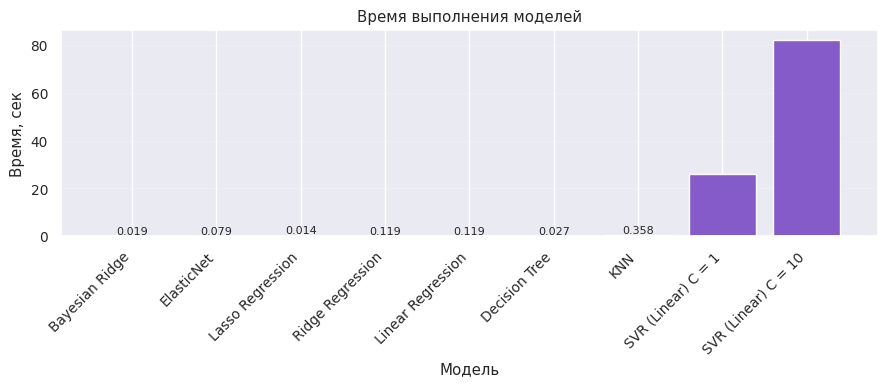

In [ ]:
my_cmap = LinearSegmentedColormap.from_list("my_palette",
                                            ["#ffffff", "#9370DB", "#4B0082"])

plt.figure(figsize=(9, 4))
bars = plt.bar(results_df["Model"], results_df["Time"],
               color=[my_cmap(0.6)]*len(results_df))
plt.title("Время выполнения моделей")
plt.xlabel("Модель")
plt.ylabel("Время, сек")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)

for bar, t in zip(bars, exec_time1):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{t:.3f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

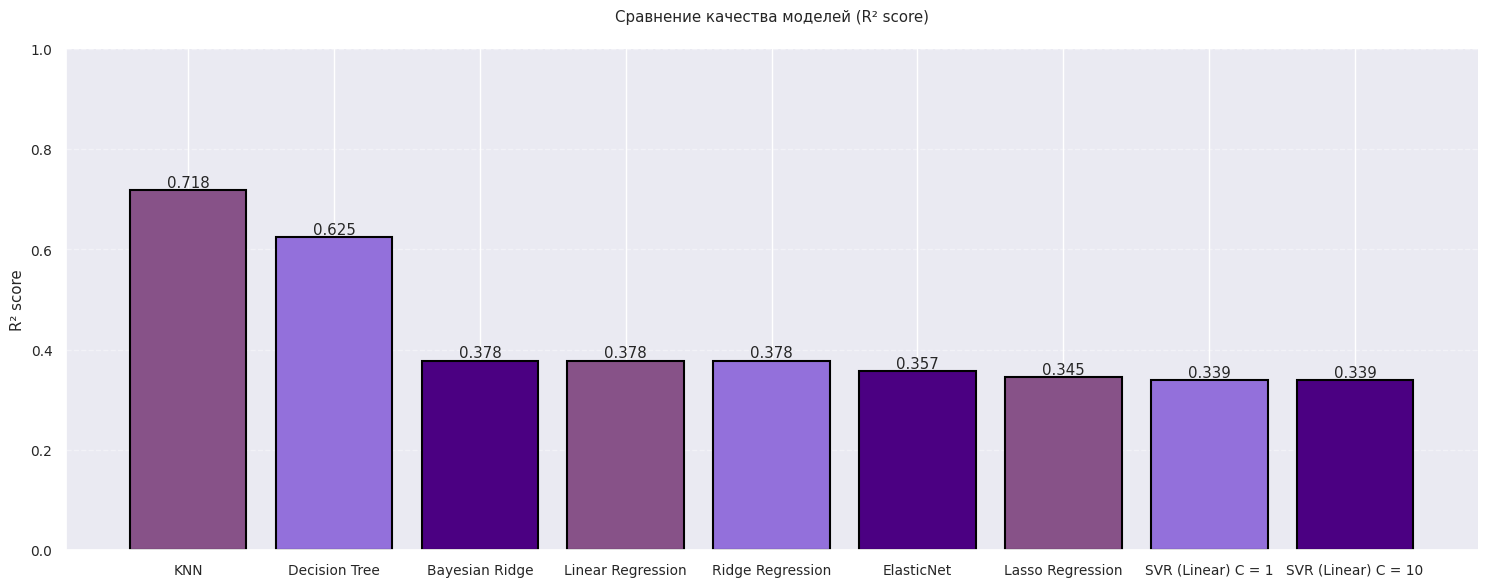

In [ ]:
results_sorted = results_df.sort_values('R2', ascending=False)
models_names = results_sorted['Model'].values
r2_scores    = results_sorted['R2'].values
plt.figure(figsize=(15, 6))
bars = plt.bar(models_names, r2_scores,
               color=['#875288', '#9370DB', '#4B0082'],
               edgecolor='black', linewidth=1.5)

plt.title('Сравнение качества моделей (R² score)', pad=20)
plt.ylabel('R² score')
plt.ylim(0, 1)
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.4)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

После нормализации R² и другие метрики у KNN  вырос — это ожидаемо, поскольку метод чувствителен к масштабу признаков. Для линейных моделей и решающего дерева метрика почти не изменилась. Тем не менее даже лучшие результаты остаются низкими, а R² на обучении столь же невысок, что является признаком недообучения, поэтому перейдем к методам ансамблей.

# 4. бэггинговые модели

Первым методом является бэггинг и его частный случай случайный лес, ниже расмотрены основные теоретические аспекты работы данного алгоритма:

Пусть дана обучающая выборка $X$. Далее генеируются выборки
$$
X_1,\; X_2,\; \dots,\; X_M.
$$  

На каждой подвыборке обучаем базовый алгоритм $$a_i(x)$$.  
Итоговый ансамблевый классификатор усредняет их ответы  
$$
a(x)=\frac{1}{M}\sum_{i=1}^{M} a_i(x).
$$  

Рассмотрим задачу регрессии с базовыми алгоритмами — $$b_1(x),\,b_2(x),\dots,b_n(x)$$,  
Предположим, что существует истинная функция ответа для всех объектов $y(x)$, а также задано распределение на объектах $p(x)$  
Ошибка $i$-й модели:

$$
\varepsilon_i(x)=b_i(x)-y(x), \qquad i=1,\dots,n.
$$  

Среднеквадратичное ожидание ошибки:

$$
\mathbb{E}_x\!\bigl[(b_i(x)-y(x))^{2}\bigr]=
\mathbb{E}_x\!\bigl[\varepsilon_i^{2}(x)\bigr].
$$  

Средняя ошибка по всем моделям:

$$
\mathbb{E}_1=\frac{1}{n}\,
\mathbb{E}_x\!\Bigl[\sum_{i=1}^{n}\varepsilon_i^{2}(x)\Bigr].
$$  

Предположим, что ошибки несмещённые и некоррелированы:

$$
\mathbb{E}_x[\varepsilon_i(x)]=0,\qquad
\mathbb{E}_x[\varepsilon_i(x)\,\varepsilon_j(x)]=0,\; i\neq j.
$$  

*Усреднённая функция*

Определим новую регрессионную функцию

$$
a(x)=\frac{1}{n}\sum_{i=1}^{n} b_i(x).
$$  

Её среднеквадратичная ошибка:

$$
\begin{aligned}
\mathbb{E}_n
&=\mathbb{E}_x\!\Bigl(\tfrac1n\sum_{i=1}^{n} b_i(x)-y(x)\Bigr)^2\\
&=\mathbb{E}_x\!\Bigl(\tfrac1n\sum_{i=1}^{n}\varepsilon_i(x)\Bigr)^2\\
&=\frac{1}{n^{2}}\,
\mathbb{E}_x\!\Bigl(\sum_{i=1}^{n}\varepsilon_i^{2}(x)
+\sum_{i\neq j}\varepsilon_i(x)\varepsilon_j(x)\Bigr)\\
&=\frac{1}{n}\,\mathbb{E}_1.
\end{aligned}
$$  

**Итого:** усреднение уменьшает MSE в $n$ раз.


Случайный лес является бэггингом со случайным выбором деревьев для построение, это является плюсом, так как:

Формально дисперсия ансамбля определяется:

$$
\operatorname{Var}\!\bigl(a(x)\bigr)=\rho\,\sigma^{2}+\frac{1-\rho}{M}\,\sigma^{2},
$$  

где $\rho$ — средняя корреляция между деревьями.  
Random Forest уменьшает $\rho$, поэтому итоговая дисперсия меньше, чем у чистого бэггинга при том же $M$.


Построим ансамбль алгоритмов, где базовый алгоритм — это решающее дерево. Будем строить по следующей схеме:

Для построения
i-го дерева:

Сначала, как в обычном бэггинге, из обучающей выборки
X выбирается с возвращением случайная подвыборка
$X^i$

  того же размера, что и
X.

В процессе обучения каждого дерева в каждой вершине случайно выбираются
n<N признаков, где
N — полное число признаков (метод случайных подпространств), и среди них ищется оптимальный сплит. Такой приём как раз позволяет управлять степенью скоррелированности базовых алгоритмов.

Чтобы получить предсказание ансамбля на тестовом объекте, усредняем отдельные ответы деревьев (для регрессии) или берём самый популярный класс (для классификации).
 Мы построили Random Forest (случайный лес) — комбинацию бэггинга и метода случайных подпространств над решающими деревьями.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=500, max_depth=10, n_jobs=-1, random_state=42
    ),
    "Extra Trees": ExtraTreesRegressor(
        n_estimators=500, max_depth=10, n_jobs=-1, random_state=42
    ),
    "Bagging (DT)": BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=10, random_state=42),
        n_estimators=500,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    ),
}

In [ ]:
results2   = []
exec_time2 = []
feature_importances = []

for name, model in models.items():
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    t1 = time.perf_counter()
    exec_time2.append(round(t1 - t0, 4))
    mae   = mean_absolute_error(y_test, y_pred)
    mse   = mean_squared_error(y_test, y_pred)
    rmse  = np.sqrt(mse)
    r2    = r2_score(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)

    results2.append({
        "Model": name,
        "MAE":   mae,
        "MSE":   mse,
        "RMSE":  rmse,
        "R2":    r2,
        "MedAE": medae,
        "Time":  exec_time2[-1]
    })

    # сохраняем важности признаков, если они есть
    if hasattr(model, "feature_importances_"):
        fi = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": model.feature_importances_,
            "Model": name
        })
        feature_importances.append(fi)

results_df = pd.DataFrame(results2)
feature_importances = (pd.concat(feature_importances, ignore_index=True)
                       if feature_importances else None)

In [ ]:
results_df

,Model,MAE,MSE,RMSE,R2,MedAE,Time
0,Random Forest,0.782522,1.582849,1.258113,0.737178,0.404467,9.3457
1,Extra Trees,0.789540,1.573230,1.254285,0.738775,0.415090,6.7473
2,Bagging (DT),0.782516,1.582998,1.258172,0.737153,0.404800,10.2116


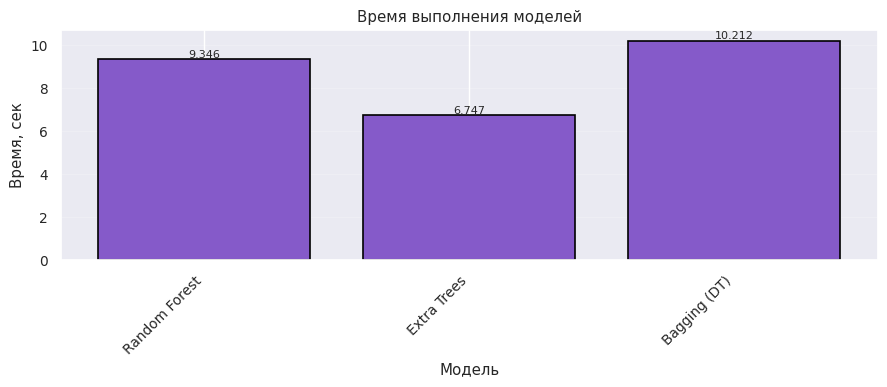

In [ ]:
my_cmap = LinearSegmentedColormap.from_list(
    "my_palette", ["#ffffff", "#9370DB", "#4B0082"]
)

plt.figure(figsize=(9, 4))
bars = plt.bar(results_df["Model"], results_df["Time"],
               color=[my_cmap(0.6)] * len(results_df),
               edgecolor='black', linewidth=1.2)

plt.title("Время выполнения моделей")
plt.xlabel("Модель")
plt.ylabel("Время, сек")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)

for bar, t in zip(bars, exec_time2):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{t:.3f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

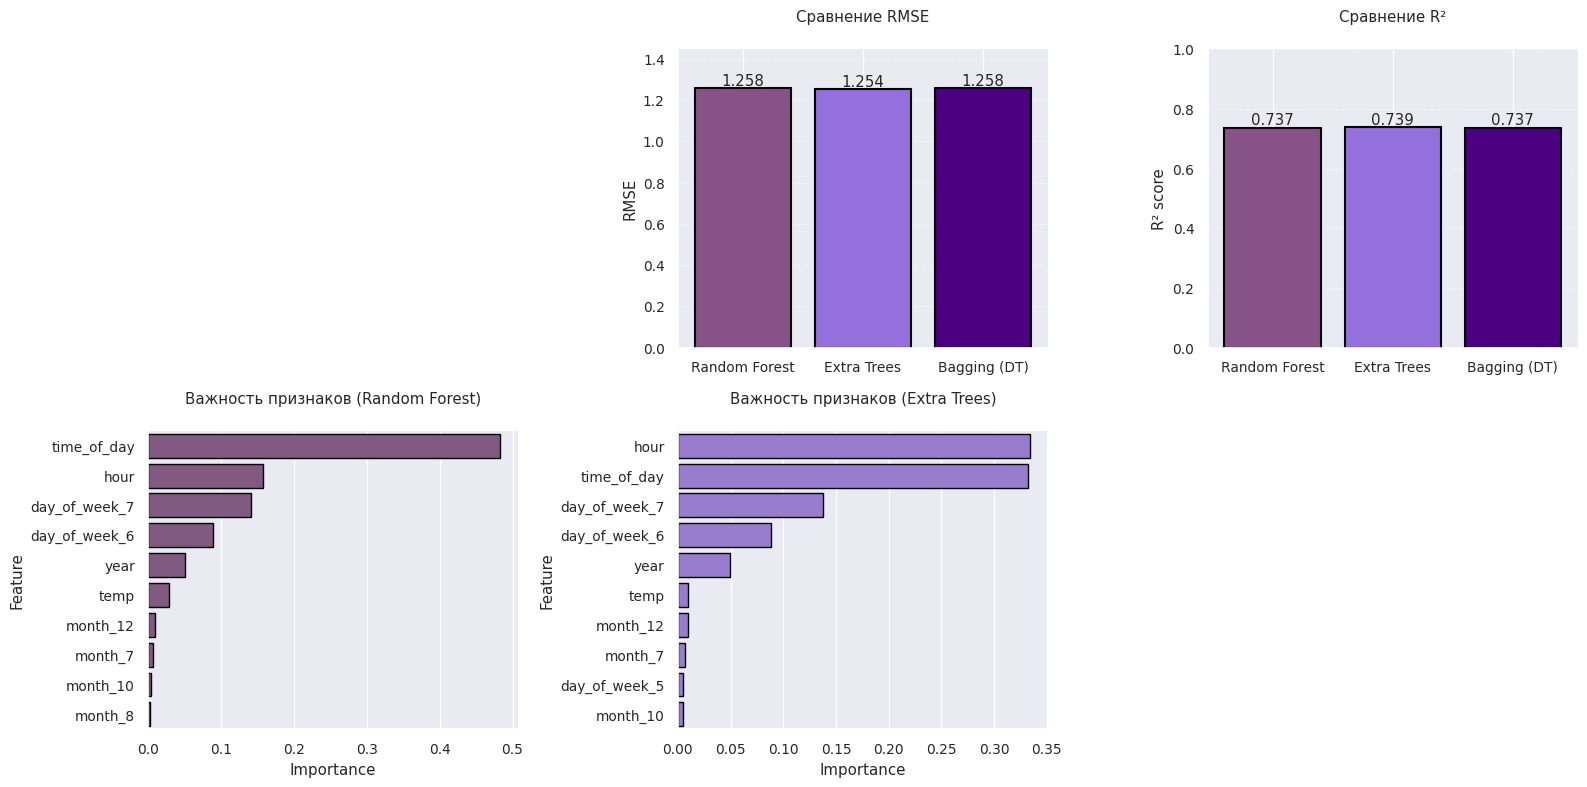

In [ ]:
hex_colors = ['#875288', '#9370DB', '#4B0082', '#6A5ACD', '#483D8B']
palette    = dict(zip(results_df['Model'], hex_colors[:len(results_df)]))
plt.figure(figsize=(16, 8))
plt.subplot(2, 3, 2)
bars = plt.bar(results_df['Model'], results_df['RMSE'],
               color=[palette[m] for m in results_df['Model']],
               edgecolor='black', linewidth=1.5)

plt.title('Сравнение RMSE', pad=20)
plt.ylabel('RMSE')
plt.ylim(0, results_df['RMSE'].max()*1.15)
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.4)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h,
             f'{h:.3f}', ha='center', va='bottom')

plt.subplot(2, 3, 3)
bars_r2 = plt.bar(results_df['Model'], results_df['R2'],
                  color=[palette[m] for m in results_df['Model']],
                  edgecolor='black', linewidth=1.5)

plt.title('Сравнение R²', pad=20)
plt.ylabel('R² score')
plt.ylim(0, 1)
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.4)

for bar in bars_r2:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h,
             f'{h:.3f}', ha='center', va='bottom')

plt.subplot(2, 3, 4)
rf_imp = (feature_importances[feature_importances['Model'] == 'Random Forest']
          .sort_values('Importance', ascending=False)
          .head(10))

sns.barplot(x='Importance', y='Feature', data=rf_imp,
            color=palette['Random Forest'],
            edgecolor='black', linewidth=1)
plt.title('Важность признаков (Random Forest)', pad=20)
sns.despine()
plt.subplot(2, 3, 5)
et_imp = (feature_importances[feature_importances['Model'] == 'Extra Trees']
          .sort_values('Importance', ascending=False)
          .head(10))
sns.barplot(x='Importance', y='Feature', data=et_imp,
            color=palette['Extra Trees'],
            edgecolor='black', linewidth=1)
plt.title('Важность признаков (Extra Trees)', pad=20)
sns.despine()
plt.tight_layout()
plt.show()

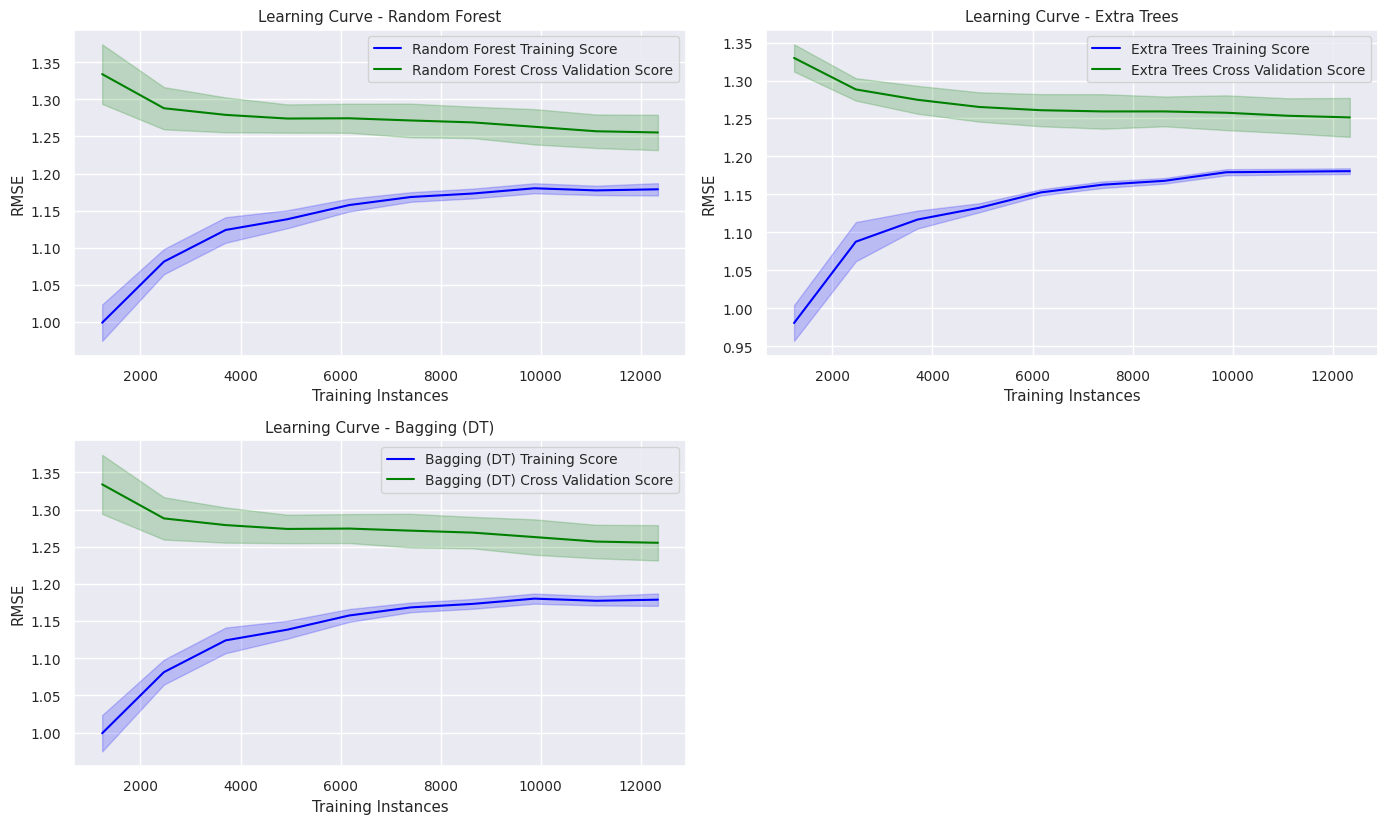

In [ ]:
plt.figure(figsize=(14, 12))
for i, (name, model) in enumerate(models.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_root_mean_squared_error'
    )
    train_mean = -train_scores.mean(axis=1)
    test_mean = -test_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_std = test_scores.std(axis=1)
    plt.subplot(3, 2, i+1)
    plt.plot(train_sizes, train_mean, label=f'{name} Training Score', color='blue')
    plt.plot(train_sizes, test_mean, label=f'{name} Cross Validation Score', color='green')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

    plt.title(f'Learning Curve - {name}')
    plt.xlabel('Training Instances')
    plt.ylabel('RMSE')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

У нас получились гораздо более лучше показатели($R^2$ = 0.73, RMSE = 1.25 на валидационной выборке), но видно что 8000 тысяч наблюдений модели выходят на плато, это также является признаком недооубчения. Перейдем к еще более сильному тиу моделей, бустингу.

#5. Бустинговые  модели

Пусть дана обучающая выборка $X = \{(x_i, y_i)\}_{i=1}^N$.
В бустинге регрессионные модели $b_m(x)$ строятся последовательно. Каждая последующая модель $b_m(x)$ обучается на ошибках (остатках), допущенных текущей композицией моделей $a_{m-1}(x)$.

***Инициализация ансамбля***
Ансамбль инициализируется некоторой простой моделью $a_0(x)$. Часто в качестве $a_0(x)$ выбирают константу, равную среднему значению целевой переменной $y$ на обучающей выборке:
$$ a_0(x) = \frac{1}{N} \sum_{i=1}^N y_i $$
Ошибку начальной модели на объекте $x$ обозначим как $\varepsilon_0(x) = y(x) - a_0(x)$.


**Итеративное построение ансамбля**

Для каждого шага $m = 1, \dots, M$ выполняются следующие действия:

**Вычисление остатков.** Сначала для каждого объекта $x_i$ вычисляются текущие остатки (ошибки) $\varepsilon_{m-1}(x_i)$. Эти остатки являются целевыми значениями для построения новой базовой модели на данном шаге. Формула для остатков:
$$
r_{m,i} = y_i - a_{m-1}(x_i) \quad (= \varepsilon_{m-1}(x_i))
$$
Важно отметить, что в общем случае градиентного бустинга значения $r_{m,i}$ являются значениями антиградиента функции потерь.

**Обучение новой базовой модели $b_m(x)$.** Затем происходит обучение новой базовой модели $b_m(x)$. Эта модель обучается на данных $(x_i, r_{m,i})$, то есть она стремится как можно точнее аппроксимировать вычисленные на предыдущем этапе остатки:
$$
b_m(x) \approx r_m(x)
$$

**Обновление ансамбля.** Наконец, текущий ансамбль моделей $a_m(x)$ обновляется. Это делается путем добавления только что обученной новой базовой модели $b_m(x)$ к ансамблю предыдущего шага $a_{m-1}(x)$, с некоторым весом, который называется темпом обучения $\eta$:
$$
a_m(x) = a_{m-1}(x) + \eta \cdot b_m(x)
$$
Здесь $\eta$ (eta) — это темп обучения (learning rate), который обычно находится в диапазоне $0 < \eta \le 1$.

*Итоговая регрессионная функция*

Определим итоговую регрессионную функцию ансамбля после $M$ шагов:
$$ a_M(x) = a_0(x) + \sum_{m=1}^{M} \eta \cdot b_m(x) $$
Иногда $a_0(x)$ включают в сумму или полагают $a_0(x)=0$ и подбирают смещение позже или первой моделью $b_1(x)$.

Её среднеквадратичная ошибка (анализ):

Обозначим ошибку (остаток) ансамбля на шаге $m$ как $\varepsilon_m(x) = y(x) - a_m(x)$.
Выразим ошибку $\varepsilon_m(x)$ через ошибку предыдущего шага $\varepsilon_{m-1}(x)$:
$$
\begin{aligned}
\varepsilon_m(x) &= y(x) - a_m(x) \\
&= y(x) - (a_{m-1}(x) + \eta \cdot b_m(x)) \\
&= (y(x) - a_{m-1}(x)) - \eta \cdot b_m(x) \\
&= \varepsilon_{m-1}(x) - \eta \cdot b_m(x)
\end{aligned}
$$
Модель $b_m(x)$ обучается предсказывать $\varepsilon_{m-1}(x)$. Пусть $b_m(x) = \varepsilon_{m-1}(x) - \delta_m(x)$, где $\delta_m(x)$ — это ошибка модели $b_m(x)$ в предсказании остатка $\varepsilon_{m-1}(x)$ (то есть, та часть $\varepsilon_{m-1}(x)$, которую $b_m(x)$ не смогла объяснить).
Тогда рекуррентное соотношение для ошибки ансамбля:
$$
\begin{aligned}
\varepsilon_m(x) &= \varepsilon_{m-1}(x) - \eta (\varepsilon_{m-1}(x) - \delta_m(x)) \\
&= (1-\eta)\varepsilon_{m-1}(x) + \eta \delta_m(x)
\end{aligned}
$$
Среднеквадратичная ошибка (MSE) ансамбля на шаге $m$, $\text{MSE}_m = \mathbb{E}_x[\varepsilon_m(x)^2]$, связана с $\text{MSE}_{m-1} = \mathbb{E}_x[\varepsilon_{m-1}(x)^2]$ следующим образом:
$$
\begin{aligned}
\text{MSE}_m &= \mathbb{E}_x[((1-\eta)\varepsilon_{m-1}(x) + \eta \delta_m(x))^2] \\
&= (1-\eta)^2 \mathbb{E}_x[\varepsilon_{m-1}(x)^2] + \eta^2 \mathbb{E}_x[\delta_m(x)^2] + 2\eta(1-\eta)\mathbb{E}_x[\varepsilon_{m-1}(x)\delta_m(x)] \\
&= (1-\eta)^2 \text{MSE}_{m-1} + \eta^2 \mathbb{E}_x[\delta_m(x)^2] + 2\eta(1-\eta)\text{Cov}(\varepsilon_{m-1}(x), \delta_m(x))
\end{aligned}
$$
(Последний член упрощается до ковариации, если ожидания $\varepsilon_{m-1}(x)$ и $\delta_m(x)$ равны нулю, что не всегда так для $\varepsilon_{m-1}(x)$ на промежуточных шагах).
Если каждая базовая модель $b_m(x)$ является хотя бы "слабым учеником", то есть $\mathbb{E}_x[\delta_m(x)^2]$ (ошибка $b_m$ на остатках) меньше, чем $\text{MSE}_{m-1}$, и $\eta$ достаточно мало, то $\text{MSE}_m < \text{MSE}_{m-1}$.

**Итого:** Бустинг последовательно уменьшает ошибку ансамбля, нацеливаясь на снижение смещения (bias). Каждая новая модель $b_m(x)$ фокусируется на исправлении ошибок $\varepsilon_{m-1}(x)$, допущенных предыдущим ансамблем. Если базовые модели способны улавливать структуру в остатках (т.е. $\mathbb{E}_x[\delta_m(x)^2]$ не слишком велико) и темп обучения $\eta$ выбран корректно, среднеквадратичная ошибка ансамбля будет уменьшаться с каждой итерацией. В отличие от идеализированного бэггинга, где MSE может уменьшаться пропорционально числу моделей $n$ (при некоррелированных ошибках), для бустинга такой простой зависимости нет, и процесс более сложен.

**Градиентный бустинг vs. AdaBoost: Ключевые различия**

Хотя и градиентный бустинг, и AdaBoost являются ансамблевыми методами, которые последовательно строят слабые модели для создания одной сильной, они делают это принципиально по-разному:

**AdaBoost (Adaptive Boosting)**

1.  **Фокус на ошибках через веса объектов:**
    *   AdaBoost итеративно обучает слабые классификаторы (например, "пни решений" – деревья глубиной 1).
    *   На каждом шаге он **увеличивает веса объектов, которые были неправильно классифицированы** предыдущей моделью, и уменьшает веса правильно классифицированных.
    *   Таким образом, каждая следующая модель сильнее фокусируется на "сложных" объектах, которые предыдущие модели не смогли правильно обработать.
    *   Итоговая модель – это взвешенная сумма (голосование) всех слабых классификаторов, где вес каждого классификатора зависит от его точности.

2.  **Неявная функция потерь:**
    * AdaBoost неявно оптимизирует экспоненциальную функцию потерь:
$$
L(y, f(x)) = e^{-y f(x)}
$$

3.  **Тип задач:**
    *   Классически разработан и наиболее известен для задач бинарной классификации, хотя существуют адаптации и для многоклассовой классификации и регрессии.

**Градиентный бустинг**

1.  **Фокус на ошибках через остатки/градиенты:**
    *   Градиентный бустинг строит каждую новую модель так, чтобы она **предсказывала остатки (ошибки) или, в более общем случае, отрицательный градиент функции потерь** предыдущего ансамбля.
    *   То есть, каждая новая модель пытается исправить то, что предыдущий ансамбль предсказал неверно, непосредственно аппроксимируя "направление" и "величину" ошибки.
    *   Итоговая модель – это сумма начальной модели и всех последовательно добавленных моделей (обычно с некоторым темпом обучения).

2.  **Явная и гибкая функция потерь:**
    *   Градиентный бустинг может использовать любую дифференцируемую функцию потерь, что делает его очень гибким.
    *   Для регрессии это часто среднеквадратичная ошибка (MSE), для классификации – логистическая функция потерь (log-loss) и т.д.

3.  **Тип задач:**
    *   Очень универсален, эффективно применяется как для задач регрессии, так и для задач классификации.


**Краткое резюме отличий:**

*   **Способ исправления ошибок:**
    *   **AdaBoost:** Перевзвешивает объекты, чтобы следующие модели фокусировались на ранее неверно классифицированных.
    *   **Градиентный бустинг:** Новые модели обучаются напрямую на остатках (или градиентах функции потерь) предыдущего ансамбля.
*   **Влияние на слабые модели:**
    *   **AdaBoost:** Изменяет распределение данных для каждой следующей слабой модели.
    *   **Градиентный бустинг:** Изменяет целевую переменную (на остатки/градиенты) для каждой следующей слабой модели.
*   **Функция потерь:**
    *   **AdaBoost:** Обычно использует экспоненциальную функцию потерь (часто неявно).
    *   **Градиентный бустинг:** Позволяет использовать широкий спектр дифференцируемых функций потерь, что дает большую гибкость.

В то время как AdaBoost был одним из первых успешных алгоритмов бустинга, градиентный бустинг (и его современные реализации, такие как XGBoost, LightGBM, CatBoost) часто демонстрирует более высокую точность и гибкость на широком круге задач.
Рассмотрим их подробнее:

**Основные поппулярные бустинги**


Описанный выше итеративный подход лежит в основе многих мощных алгоритмов машинного обучения. Среди наиболее известных и широко используемых реализаций градиентного бустинга на деревьях решений выделяются XGBoost, LightGBM и CatBoost. Каждая из них предлагает свои оптимизации и особенности, направленные на повышение точности, скорости обучения и удобства использования.

**XGBoost**

XGBoost стал одним из первых фреймворков, который значительно популяризировал градиентный бустинг благодаря своей высокой производительности и точности.
*   **Регуляризация:** Включает L1 (Lasso) и L2 (Ridge) регуляризацию в функцию потерь при построении каждого дерева, что помогает предотвратить переобучение. Функция потерь для $m$-го дерева $b_m$ выглядит примерно так:
$$ \text{Obj}^{(m)} = \sum_{i=1}^N L(y_i, a_{m-1}(x_i) + b_m(x_i)) + \Omega(b_m) $$
где $\Omega(b_m) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2$ ($T$ - число листьев, $w_j$ - веса в листьях).
*   **Обработка пропущенных значений:** XGBoost имеет встроенный механизм для обработки пропущенных значений. При построении дерева он определяет оптимальное направление для объектов с пропущенными значениями на каждом узле.
*   **Параллелизация и оптимизация:** Эффективно использует многопоточность для построения деревьев (на уровне узлов и признаков) и оптимизирован для работы с большими наборами данных, в том числе разреженными.
*   **Кастомизация:** Позволяет определять собственные функции потерь и метрики качества.

**LightGBM**

LightGBM, разработанный Microsoft, ориентирован на высокую скорость обучения и эффективность использования памяти, особенно на больших датасетах.
*   **Gradient-based One-Side Sampling (GOSS):** Вместо использования всех данных для вычисления градиентов, GOSS сохраняет все объекты с большими градиентами (которые плохо предсказаны) и случайным образом выбирает часть объектов с малыми градиентами. Это ускоряет обучение без значительной потери точности.
*   **Exclusive Feature Bundling (EFB):** Метод для уменьшения числа признаков путем объединения взаимоисключающих признаков (которые редко принимают ненулевые значения одновременно).
*   **Рост деревьев по листьям (Leaf-wise tree growth):** В отличие от традиционного роста по уровням (level-wise), LightGBM выбирает лист с наибольшим потенциальным уменьшением потерь и делит его. Это может привести к построению более глубоких и асимметричных деревьев, но часто более точных.
*   **Оптимизированная работа с категориальными признаками:** Хотя рекомендуется их предварительное кодирование, LightGBM может обрабатывать их более эффективно, чем некоторые другие алгоритмы, указывая их тип.

**CatBoost (Categorical Boosting)**

CatBoost, разработанный Яндексом, делает особый акцент на качественной обработке категориальных признаков и устойчивости к переобучению.
*   **Продвинутая обработка категориальных признаков:** CatBoost использует комбинацию методов, включая Ordered Boosting и различные способы преобразования категориальных признаков в числовые (например, на основе статистики по целевой переменной, но с защитой от target leakage). Это часто избавляет от необходимости ручного кодирования категорий.
*   **Ordered Boosting:** Модификация градиентного бустинга, которая использует случайные перестановки обучающей выборки для построения моделей, что помогает бороться с проблемой смещения предсказаний (prediction shift) и утечкой целевой переменной при обработке категориальных признаков.
*   **Симметричные (обливионные) деревья (Symmetric/Oblivious Trees):** Все узлы на одном уровне дерева используют одно и то же условие для разбиения. Это упрощает модель, ускоряет предсказание и является формой регуляризации.
*   **Меньшая чувствительность к подбору гиперпараметров:** Часто показывает хорошие результаты с параметрами по умолчанию.
*   **Встроенные инструменты для анализа:** Включает средства для визуализации процесса обучения и важности признаков.

Эти три библиотеки являются столпами современного градиентного бустинга и широко применяются в соревнованиях по машинному обучению и в промышленных задачах благодаря своей эффективности и гибкости. Выбор конкретной библиотеки часто зависит от специфики данных (особенно наличия категориальных признаков), требований к скорости обучения и доступных вычислительных ресурсов.

In [ ]:
cat_cols = ['day_of_week', 'month', 'year']
target   = 'traf'
num_cols = df.columns.difference(cat_cols + [target])

X = df[cat_cols + list(num_cols)].copy()
y = df[target]
for c in cat_cols:
    X[c] = X[c].astype('category')
X_enc = X.copy()
for c in cat_cols:
    X_enc[c] = X_enc[c].cat.codes
X_train, X_test, y_train, y_test   = train_test_split(
    X,      y, test_size=0.2, random_state=42, shuffle=True)
Xtr_enc, Xte_enc, _, _             = train_test_split(
    X_enc,  y, test_size=0.2, random_state=42, shuffle=True)

cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]   # CatBoost

In [ ]:
models = {
    "LightGBM": LGBMRegressor(
        n_estimators=600, max_depth=-1, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42),

    "XGBoost": XGBRegressor(
        n_estimators=600, max_depth=8, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, tree_method="hist",
        enable_categorical=True, random_state=42),

    "CatBoost": CatBoostRegressor(
        iterations=600, depth=8, learning_rate=0.05,
        subsample=0.8, loss_function="RMSE",
        random_seed=42, verbose=False),

    "AdaBoost": AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=6),
        n_estimators=400, learning_rate=0.05, random_state=42),

    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=400, max_depth=3, learning_rate=0.05,
        subsample=0.8, random_state=42),

    "HistGradientBoosting": HistGradientBoostingRegressor(
        max_depth=None, learning_rate=0.05, max_iter=400,
        l2_regularization=0.0, random_state=42)
}
fit_cols = {
    "LightGBM":             X_train.columns,
    "XGBoost":              X_train.columns,
    "CatBoost":             X_train.columns,
    "AdaBoost":             Xtr_enc.columns,
    "GradientBoosting":     Xtr_enc.columns,
    "HistGradientBoosting": None
}

In [ ]:
results3, feature_importances = [], []

for name, model in models.items():
    t0 = time.perf_counter()
    if name in ["AdaBoost", "GradientBoosting", "HistGradientBoosting"]:
        model.fit(Xtr_enc, y_train)
        y_pred = model.predict(Xte_enc)
    elif name == "LightGBM":
        model.fit(X_train, y_train, categorical_feature=cat_cols)
        y_pred = model.predict(X_test)
    elif name == "CatBoost":
        model.fit(X_train, y_train, cat_features=cat_idx)
        y_pred = model.predict(X_test)
    else:                      # XGBoost
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    exec_time3 = round(time.perf_counter() - t0, 4)

    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results3.append({
        "Model": name,
        "MAE":   mean_absolute_error(y_test, y_pred),
        "MSE":   mse,
        "RMSE":  rmse,
        "R2":    r2_score(y_test, y_pred),
        "MedAE": median_absolute_error(y_test, y_pred),
        "Time":  exec_time3
    })
    fi_vals = None
    if hasattr(model, "feature_importances_"):
        fi_vals = model.feature_importances_
    elif name == "CatBoost":
        fi_vals = model.get_feature_importance(type="FeatureImportance")

    cols = fit_cols[name]
    if fi_vals is not None and cols is not None and len(fi_vals) == len(cols):
        feature_importances.append(pd.DataFrame({
            "Feature": cols,
            "Importance": fi_vals,
            "Model": name
        }))

results_df = pd.DataFrame(results3).sort_values("RMSE")

if feature_importances:
    feature_importances = pd.concat(feature_importances, ignore_index=True)
else:
    feature_importances = pd.DataFrame(columns=["Feature", "Importance", "Model"])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 15428, number of used features: 7
[LightGBM] [Info] Start training from score 2.166840


In [ ]:
results_df3 = pd.DataFrame(results3)
results_df3

,Model,MAE,MSE,RMSE,R2,MedAE,Time
0,LightGBM,0.636772,1.027670,1.013740,0.829362,0.344105,0.8517
1,XGBoost,0.626472,1.050466,1.024922,0.825577,0.323095,2.2515
2,CatBoost,0.670168,1.150578,1.072650,0.808954,0.321273,8.3322
3,AdaBoost,0.981891,1.879296,1.370874,0.687955,0.676259,7.5361
4,GradientBoosting,0.767989,1.341340,1.158162,0.777279,0.419971,2.8322
5,HistGradientBoosting,0.634564,1.067743,1.033316,0.822708,0.333376,0.6474


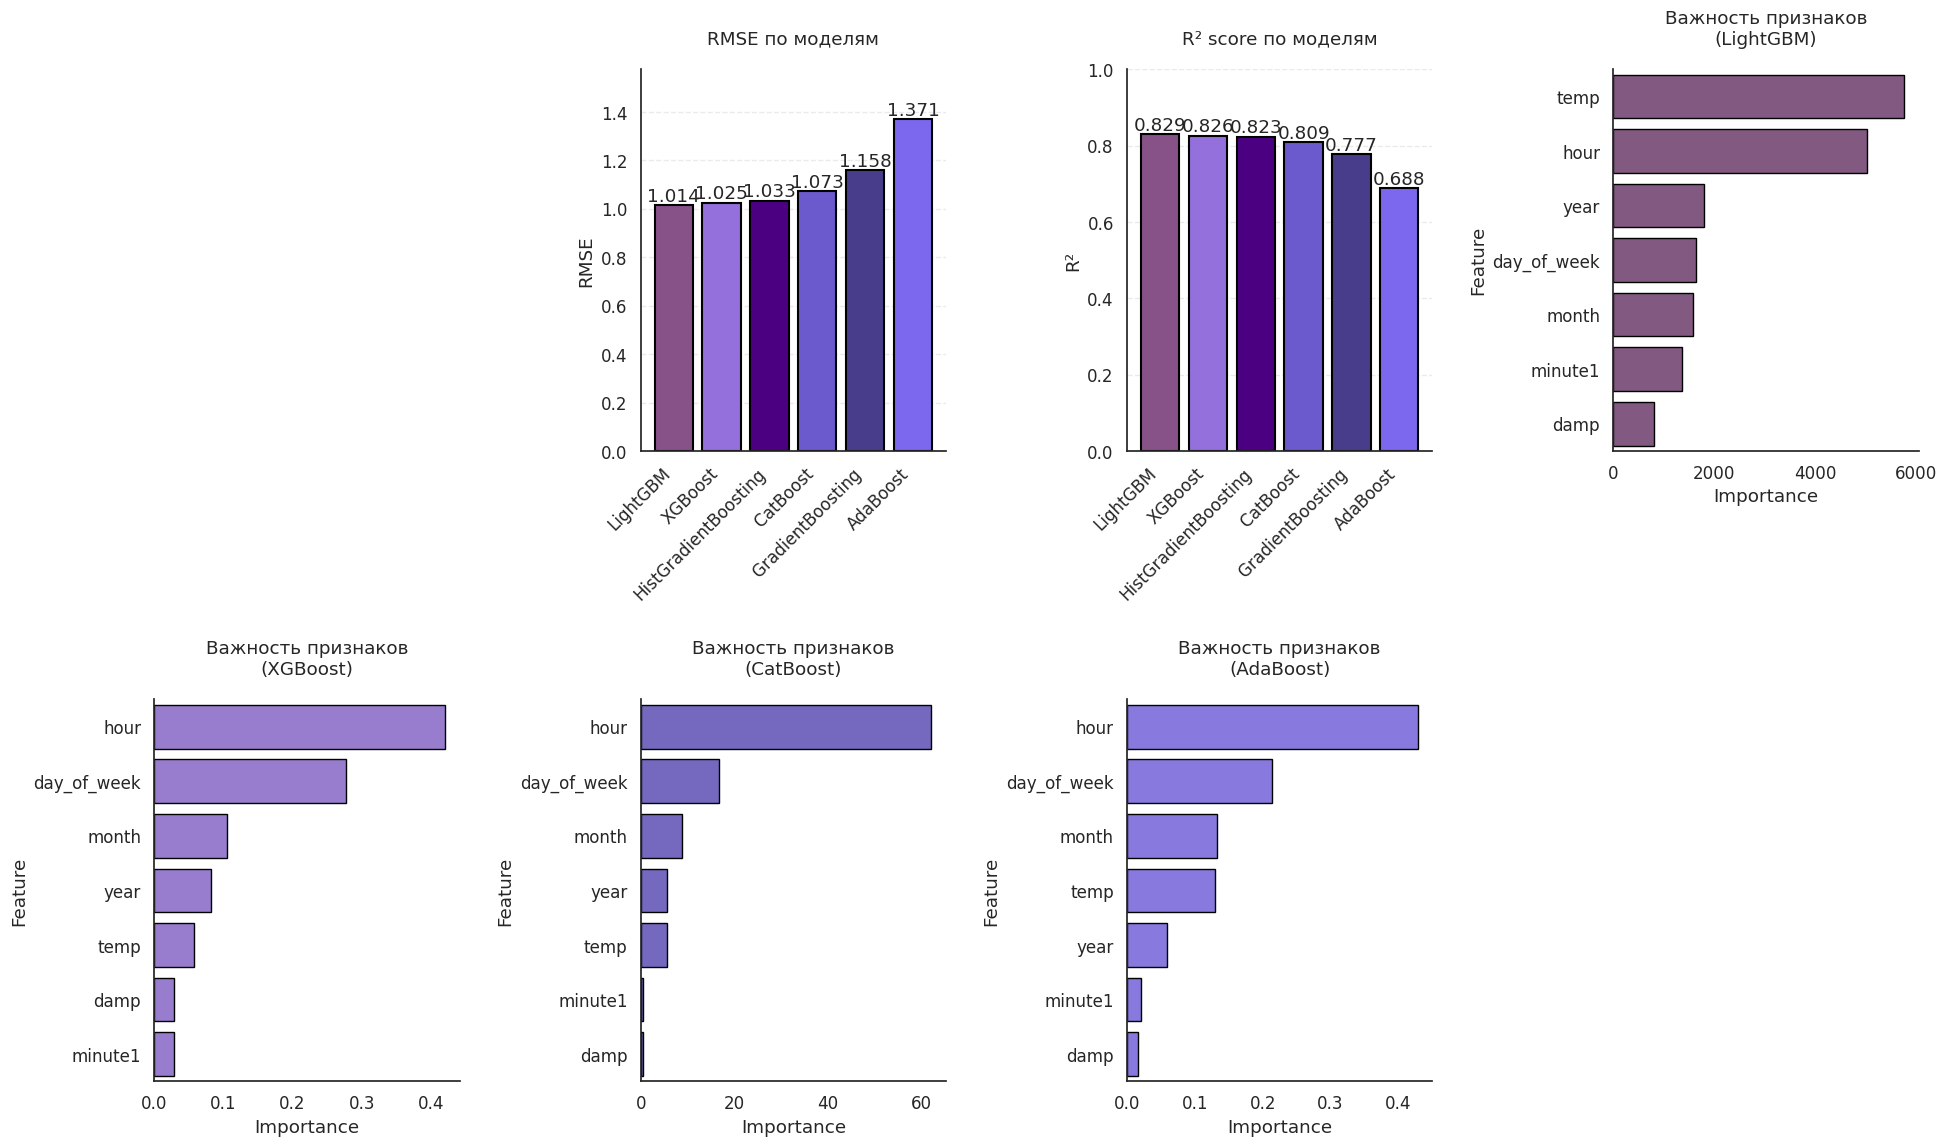

In [ ]:
unique_models = results_df['Model'].unique()
hex_colors = ['#875288', '#9370DB', '#4B0082', '#6A5ACD',
              '#483D8B', '#7B68EE', '#9A32CD', '#6959CD',
              '#8A2BE2', '#7F38EC']
palette = {m: hex_colors[i % len(hex_colors)] for i, m in enumerate(unique_models)}

sns.set_theme(style="white", font_scale=1.1)
plt.figure(figsize=(20, 12))

plt.subplot(2, 4, 2)
bars = plt.bar(results_df['Model'],
               results_df['RMSE'],
               color=[palette.get(m, '#333333') for m in results_df['Model']],
               edgecolor='black', linewidth=1.5)

plt.title('RMSE по моделям', pad=18)
plt.ylabel('RMSE')
plt.ylim(0, results_df['RMSE'].max()*1.15)
# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right') # Added this line
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.4)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h,
             f'{h:.3f}', ha='center', va='bottom')

plt.subplot(2, 4, 3)
bars_r2 = plt.bar(results_df['Model'],
                  results_df['R2'],
                  color=[palette.get(m, '#333333') for m in results_df['Model']],
                  edgecolor='black', linewidth=1.5)

plt.title('R² score по моделям', pad=18)
plt.ylabel('R²')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.4)
for bar in bars_r2:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h,
             f'{h:.3f}', ha='center', va='bottom')

fi_models = feature_importances['Model'].unique()
num_fi_plots_to_show = min(len(fi_models), 4)

for i_plot, m_idx in enumerate(range(num_fi_plots_to_show)):
    model_name = fi_models[m_idx]
    subplot_idx = 4 + i_plot
    if subplot_idx > 8:
        break

    plt.subplot(2, 4, subplot_idx)
    fi = (feature_importances.query("Model == @model_name")
          .sort_values('Importance', ascending=False)
          .head(10))
    sns.barplot(x='Importance', y='Feature', data=fi,
                color=palette.get(model_name, '#333333'),
                edgecolor='black', linewidth=1)
    plt.title(f'Важность признаков\n({model_name})', pad=18)
    sns.despine()
plt.tight_layout(pad=2.0)

plt.show()

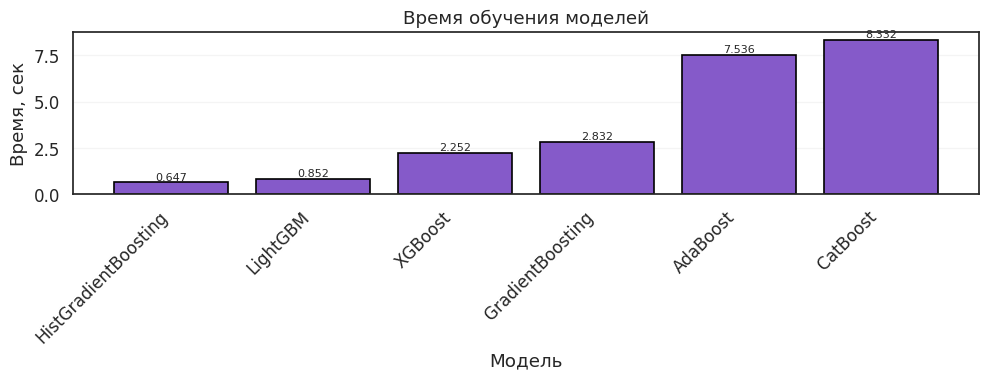

In [ ]:
my_cmap = LinearSegmentedColormap.from_list(
    "my_palette", ["#ffffff", "#9370DB", "#4B0082"]
)
time_df = results_df.sort_values("Time", ascending=True).reset_index(drop=True)

plt.figure(figsize=(10, 4))
bars = plt.bar(time_df["Model"], time_df["Time"],
               color=[my_cmap(0.6)] * len(time_df),
               edgecolor='black', linewidth=1.2)

plt.title("Время обучения моделей")
plt.xlabel("Модель")
plt.ylabel("Время, сек")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)
for bar, t in zip(bars, time_df["Time"]):
    plt.text(bar.get_x() + bar.get_width() / 2, t,
             f"{t:.3f}", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:71: FutureWarning: `fit_params` is deprecated and will be removed in version {version}. Pass parameters via `params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


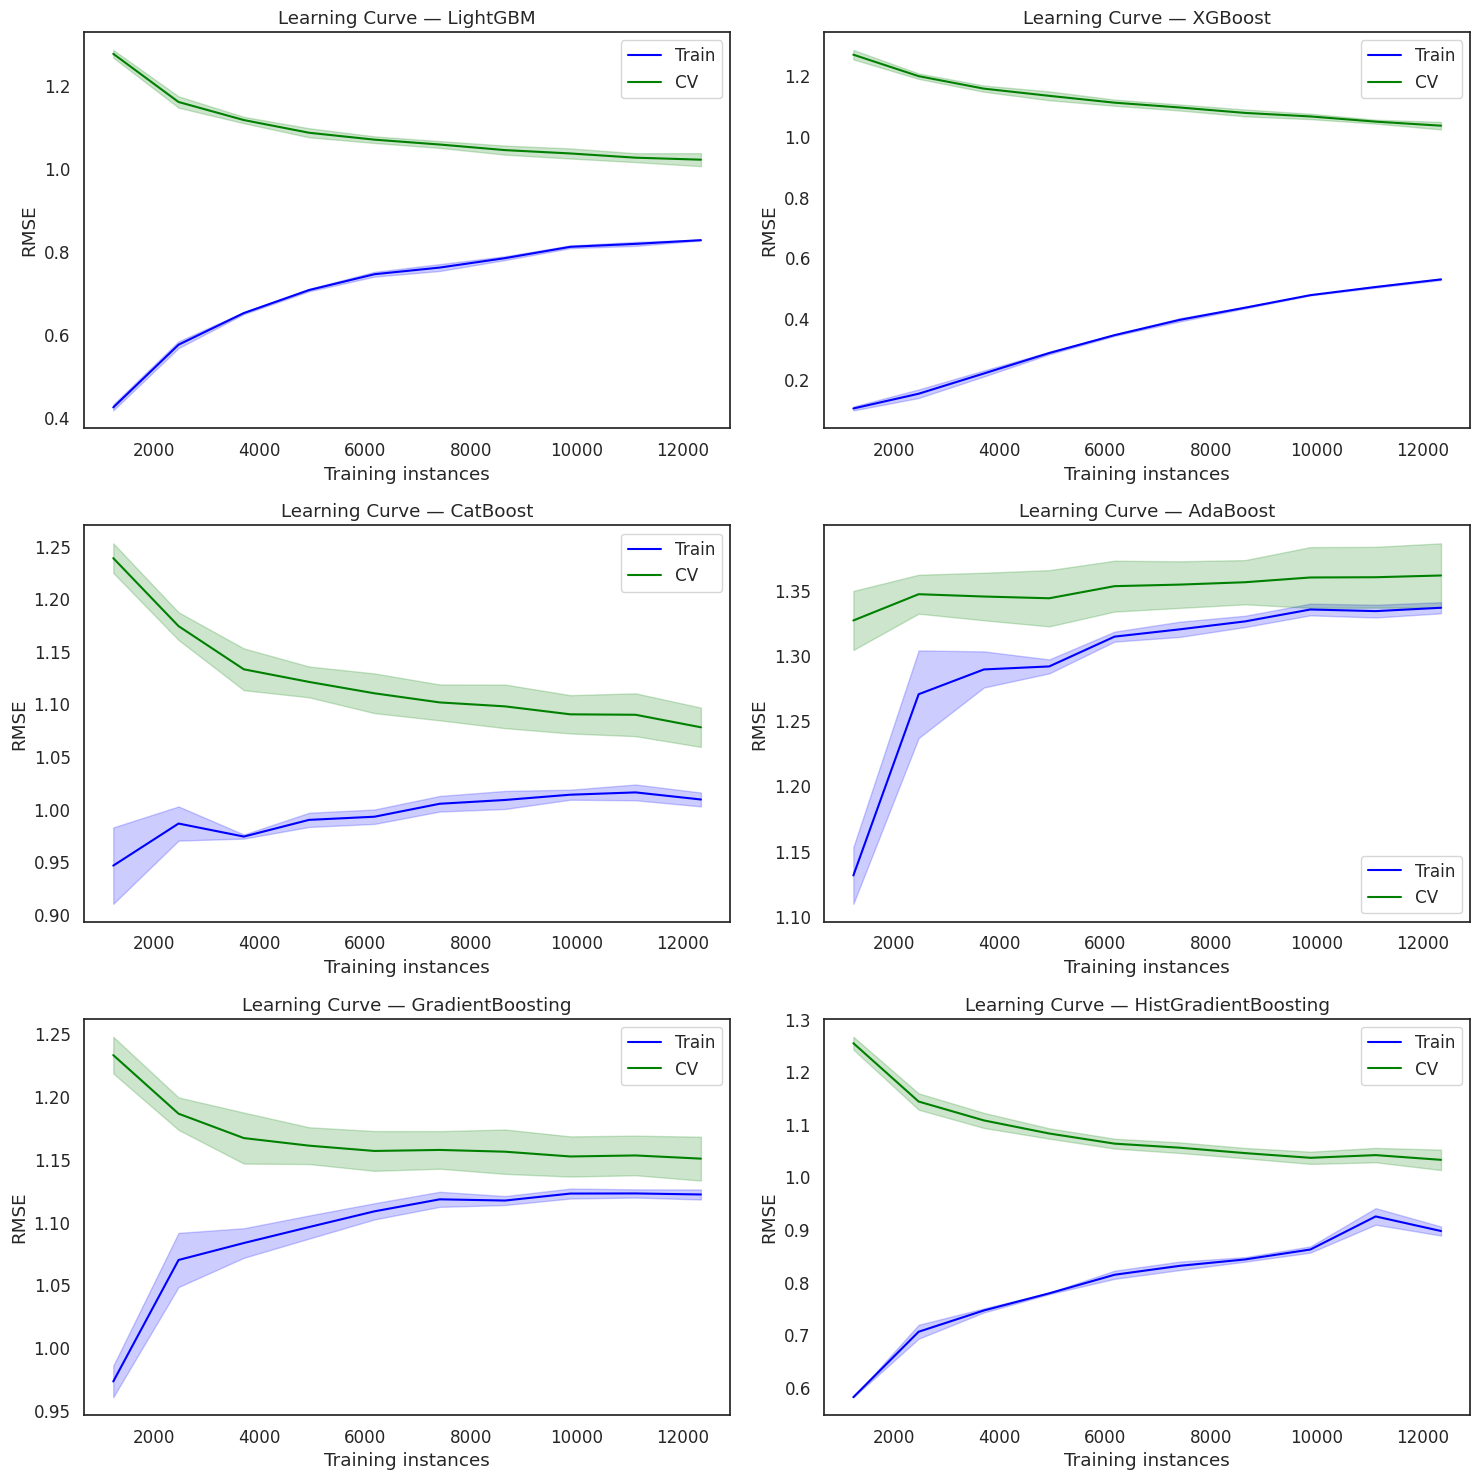

In [ ]:
encoded_models = {"AdaBoost", "GradientBoosting", "HistGradientBoosting"}
fit_params_map = {
    "LightGBM":  {"categorical_feature": cat_cols},
    "CatBoost":  {"cat_features": cat_idx},
    "XGBoost":   {},
    "AdaBoost":  {},
    "GradientBoosting": {},
    "HistGradientBoosting": {}
}
n_models = len(models)
n_cols   = 2
n_rows   = (n_models + n_cols - 1) // n_cols
plt.figure(figsize=(15, 5 * n_rows))
for i, (name, base_model) in enumerate(models.items(), start=1):
    if name in encoded_models:
        X_use, y_use = Xtr_enc, y_train
    else:
        X_use, y_use = X_train, y_train
    fit_params = fit_params_map[name]
    train_sizes, train_scores, test_scores = learning_curve(
        base_model, X_use, y_use,
        cv=5, scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1, fit_params=fit_params
    )
    train_mean = -train_scores.mean(axis=1)
    test_mean  = -test_scores.mean(axis=1)
    train_std  =  train_scores.std(axis=1)
    test_std   =  test_scores.std(axis=1)

    plt.subplot(n_rows, n_cols, i)
    plt.plot(train_sizes, train_mean, label='Train', color='blue')
    plt.plot(train_sizes, test_mean,  label='CV',    color='green')
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, test_mean  - test_std,
                     test_mean  + test_std,  alpha=0.2, color='green')

    plt.title(f'Learning Curve — {name}')
    plt.xlabel('Training instances')
    plt.ylabel('RMSE')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()


Как мы видим, что бустинги справились лучше всех с поставленной задачей, особенно lightgbm( $R^2$ = 0.829362, RMSE = 1.013740)

Попробуем оптимизировать гиперпараметры   **lightgbm**

In [ ]:
t_total_start = time.perf_counter()

def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),

        # убираем все сообщения LightGBM:
        # verbosity <= 0 выводит только FATAL/ERROR
        "verbosity": -1,

        "random_state": 42,
        "n_jobs": -1,
    }
    model = LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        categorical_feature=cat_cols
    )
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

t_opt_end = time.perf_counter()
opt_time = round(t_opt_end - t_total_start, 4)

best_params = study.best_params
best_params["verbosity"] = -1
best_model = LGBMRegressor(**best_params)

t_final_start = time.perf_counter()
best_model.fit(
    X_train, y_train,
    categorical_feature=cat_cols
)
t_final_end = time.perf_counter()
final_train_time = round(t_final_end - t_final_start, 4)

total_time = round(t_final_end - t_total_start, 4)


final_preds = best_model.predict(X_test)
mse   = mean_squared_error(y_test, final_preds)
rmse  = np.sqrt(mse)
metrics = {
    "MAE":   mean_absolute_error(y_test, final_preds),
    "MSE":   mse,
    "RMSE":  rmse,
    "R2":    r2_score(y_test, final_preds),
    "MedAE": median_absolute_error(y_test, final_preds),
    "Opt Time (s)": opt_time,
    "Final Train Time (s)": final_train_time,
    "Total Time (s)": total_time
}
results_series = pd.Series(metrics, name="LightGBM (Optuna)")
print(study)
print("\nФинальные метрики и время:")
print(results_series)


[I 2025-05-26 14:37:51,618] A new study created in memory with name: no-name-0bca82e0-e2b8-48b3-8d93-42ddeea60a56
<ipython-input-43-e5fcdc4d28f4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
[I 2025-05-26 14:37:54,018] Trial 0 finished with value: 1.0235119431272204 and parameters: {'num_leaves': 116, 'max_depth': 9, 'learning_rate': 0.03188717465666881, 'n_estimators': 661, 'min_child_samples': 39, 'subsample': 0.7268553730045537, 'colsample_bytree': 0.7742923011537639}. Best is trial 0 with value: 1.0235119431272204.
<ipython-input-43-e5fcdc4d28f4>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead


Финальные метрики и время:
MAE                      0.605130
MSE                      0.993612
RMSE                     0.996801
R2                       0.835017
MedAE                    0.297834
Opt Time (s)            58.739100
Final Train Time (s)     0.694900
Total Time (s)          59.434400
Name: LightGBM (Optuna), dtype: float64


# 6. Стекинговые модели



Стекинг — ансамблевый метод, который комбинирует предсказания нескольких **базовых моделей** (level-0) и передаёт их в **мета-модель** (level-1).  
Мета-модель учится оптимально взвешивать ответы базовых моделей, часто достигая более высокой точности, чем любая модель по-отдельности.


***Ключевая идея ***
Предсказания базовых моделей превращаются в новые признаки (*meta-features*), на которых обучается мета-модель.  
В отличие от бэггинга/бустинга, это не усреднение и не последовательное исправление ошибок, а «обучение на предсказаниях».


***Алгоритм стекинга***

1. **Кросс-валидация обучающей выборки**  
   Разбиваем исходный набор $D_{\text{train}}$ на *k* фолдов (обычно 5 – 10).  
   Это нужно, чтобы получить *out-of-fold* предсказания — то есть прогнозы на данных, которые модель не видела при своём обучении.

2. **Генерация мета-признаков**  
   Для каждого фолда $i$  
   &nbsp;&nbsp;• Обучаем базовые модели $M_1,\dots,M_N$ на $D_{\text{train-fold}_i}$.  
   &nbsp;&nbsp;• Получаем их предсказания на валидационном фолде $D_{\text{val-fold}_i}$.  
   После прохода всех фолдов объединяем эти прогнозы → получаем мета-признаки для каждого объекта $D_{\text{train}}$.  
   > Затем **переобучаем** каждую базовую модель на полном $D_{\text{train}}$, чтобы использовать их на тесте.

3. **Сбор мета-датасета**  
   *Признаки* — сформированные мета-признаки.  
   *Цель* — та же, что и у исходной задачи.  
   Обозначим этот набор $D_{\text{meta-train}}$.

4. **Обучение мета-модели**  
   Выбираем модель $M_{\text{meta}}$ (часто логистическая/линейная регрессия, небольшое дерево или лёгкий бустинг) и обучаем на $D_{\text{meta-train}}$.

5. **Предсказание на тесте**  
   • Каждая переобученная базовая модель предсказывает для $D_{\text{test}}$ → формируем мета-признаки теста.  
   • Подаём их в $M_{\text{meta}}$ → получаем итоговый прогноз стекинга.




##### Зачем это всё?

* Мета-модель может «учиться» доверять той базовой модели, которая лучше справляется в конкретной зоне признакового пространства.  
* Стекинг часто даёт +1–3 pp ROC-AUC / +2–5 % RMSE-gain по сравнению с лучшей единичной моделью при грамотной настройке.

> **Главное** — генерировать мета-признаки только *out-of-fold*, иначе возникнет утечка данных, и мета-модель переобучится.

***Преимущества стекинга:***

*   **Потенциально высокая точность:** Способен достигать очень высокой производительности, так как учится оптимально комбинировать сильные стороны различных моделей.
*   **Гибкость:** Позволяет использовать разнообразные типы базовых моделей (например, деревья решений, SVM, нейронные сети).

***Недостатки и соображения:***

*   **Сложность:** Реализация стекинга, особенно с корректной кросс-валидацией для генерации мета-признаков, может быть сложной.
*   **Вычислительные затраты:** Требует обучения нескольких базовых моделей и одной мета-модели, что может быть ресурсоемко.
*   **Риск переобучения:** Если мета-модель слишком сложная или если есть утечка данных при генерации мета-признаков, ансамбль может переобучиться.
*   **Время обучения:** Обычно занимает значительно больше времени, чем обучение одной модели.
*   **Интерпретируемость:** Итоговая модель становится еще более "черным ящиком".

Стекинг часто используется в соревнованиях по машинному обучению (например, на Kaggle) для достижения максимальной точности, когда вычислительные ресурсы и время не являются основным ограничением.

In [ ]:
cat_cols = ['day_of_week', 'month', 'year']
target   = 'traf'
num_cols = df.columns.difference(cat_cols + [target])

X_num = df[num_cols]
X_cat = pd.get_dummies(df[cat_cols].astype('category'), drop_first=False)
X     = pd.concat([X_num, X_cat], axis=1)
y     = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# БАЗОВЫЕ МОДЕЛИ
base_estimators = [
    ("rf",  RandomForestRegressor(
        n_estimators=400, max_depth=None, n_jobs=-1, random_state=42)),
    ("et",  ExtraTreesRegressor(
        n_estimators=400, max_depth=None, n_jobs=-1, random_state=42)),
    ("knn", make_pipeline(
        StandardScaler(with_mean=False),          # sparse-friendly
        KNeighborsRegressor(n_neighbors=10, weights='distance'))),
    ("svr", make_pipeline(
        StandardScaler(with_mean=False),
        SVR(C=50, gamma=0.1, epsilon=0.2)))
]
meta_model = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)

stack_cls = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

t0 = time.perf_counter()
stack_cls.fit(X_train, y_train)
train_time = round(time.perf_counter() - t0, 4)

y_pred = stack_cls.predict(X_test)

metrics = {
    "Model": "Stacking (classic)",
    "MAE":   mean_absolute_error(y_test, y_pred),
    "MSE":   mean_squared_error(y_test, y_pred),
    "RMSE":  np.sqrt(mean_squared_error(y_test, y_pred)),
    "R2":    r2_score(y_test, y_pred),
    "MedAE": median_absolute_error(y_test, y_pred),
    "Time":  train_time
}

stek = pd.Series(metrics)

In [ ]:
stek

,0
Model,Stacking (classic)
MAE,0.580751
MSE,1.046508
RMSE,1.02299
R2,0.826234
MedAE,0.31464
Time,261.431


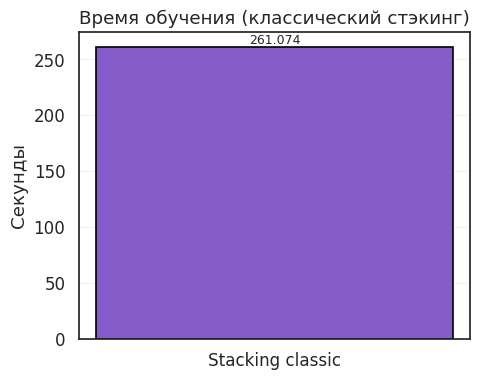

In [ ]:
my_cmap = LinearSegmentedColormap.from_list(
    "my_palette", ["#ffffff", "#9370DB", "#4B0082"])

plt.figure(figsize=(5, 4))
bars = plt.bar(["Stacking classic"], [train_time],
               color=[my_cmap(0.6)], edgecolor='black', linewidth=1.2)

plt.title("Время обучения (классический стэкинг)")
plt.ylabel("Секунды")
plt.grid(axis='y', alpha=0.2)
plt.text(bars[0].get_x() + bars[0].get_width()/2, train_time,
         f"{train_time:.3f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


***Результаты стекинга***

Как мы видим стекинг показывает относительно долгое время обучения моделм 337 секунды, хотя метрики качества $R^2$ = 0.826 и RMSE = 1.023, что хуже чем у одиночного lightgbm с подбором гиперпараметров($R^2$ = 0.834927, RMSE = 0.997073).

In [ ]:
cat_cols = ['day_of_week', 'month', 'year']
target   = 'traf'
num_cols = df.columns.difference(cat_cols + [target])

X_enc = df[cat_cols + list(num_cols)].copy()
for c in cat_cols:
    X_enc[c] = X_enc[c].astype('category').cat.codes
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42, shuffle=True
)
base_estimators = [
    ("lgbm", LGBMRegressor(
        n_estimators=600, max_depth=-1, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42)),
    ("xgb", XGBRegressor(
        n_estimators=600, max_depth=8, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, tree_method="hist",
        enable_categorical=False, random_state=42)),
    ("gbr", GradientBoostingRegressor(
        n_estimators=400, max_depth=3, learning_rate=0.05,
        subsample=0.8, random_state=42)),
    ("ada", AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=6),
        n_estimators=400, learning_rate=0.05, random_state=42))
]

meta_model = HistGradientBoostingRegressor(
    max_depth=None, learning_rate=0.05, max_iter=400,
    l2_regularization=0.0, random_state=42
)

stack = StackingRegressor(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

t0 = time.perf_counter()
stack.fit(X_train, y_train)
train_time = round(time.perf_counter() - t0, 4)

y_pred = stack.predict(X_test)

metrics = {
    "Model": "Stacking (boostings)",
    "MAE":   mean_absolute_error(y_test, y_pred),
    "MSE":   mean_squared_error(y_test, y_pred),
    "RMSE":  np.sqrt(mean_squared_error(y_test, y_pred)),
    "R2":    r2_score(y_test, y_pred),
    "MedAE": median_absolute_error(y_test, y_pred),
    "Time":  train_time
}

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
stek2 = pd.Series(metrics)
stek2

,0
Model,Stacking (boostings)
MAE,0.600652
MSE,1.056966
RMSE,1.028089
R2,0.824498
MedAE,0.30488
Time,55.9366


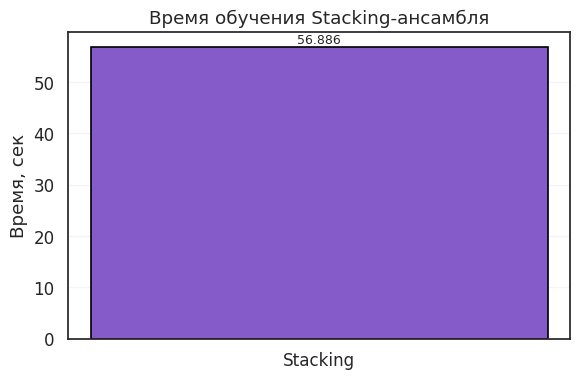

In [ ]:
my_cmap = LinearSegmentedColormap.from_list(
    "my_palette", ["#ffffff", "#9370DB", "#4B0082"]
)
plt.figure(figsize=(6, 4))
bars = plt.bar(["Stacking"], [train_time],
               color=[my_cmap(0.6)], edgecolor='black', linewidth=1.2)
plt.title("Время обучения Stacking-ансамбля")
plt.ylabel("Время, сек")
plt.grid(axis="y", alpha=0.2)

plt.text(bars[0].get_x() + bars[0].get_width() / 2,
         train_time, f"{train_time:.3f}",
         ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

Стекинг из ансамблей также не дал какого либо выиграша по качеству метрик, хотя время обучения стало в адекватных пределах

# 7. Попробуем нейросеть для сравнения результатов с классическими моделями ML

In [ ]:
cat_cols = ['day_of_week', 'month', 'year']
target   = 'traf'
num_cols = df.columns.difference(cat_cols + [target])

X_df = df[cat_cols + list(num_cols)].copy()
for c in cat_cols:
    X_df[c] = X_df[c].astype('category').cat.codes

X = X_df.values.astype(np.float32)
y = df[target].values.astype(np.float32).reshape(-1, 1)


X_seq = torch.from_numpy(X).unsqueeze(-1)      # (N, seq_len, 1)
y_tensor = torch.from_numpy(y)                # (N, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_tensor, test_size=0.2, random_state=42, shuffle=True
)

In [ ]:
batch_size = 64
train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 2. ОПРЕДЕЛЕНИЕ МОДЕЛИ -----------------------------------------------------
class RNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True)
        self.fc  = nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, (h_n, _) = self.rnn(x)          # h_n: (num_layers, batch, hidden_size)
        last_h = h_n[-1]                   # (batch, hidden_size)
        return self.fc(last_h)             # (batch, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNRegressor(input_size=1, hidden_size=64, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 50
t0 = time.perf_counter()

for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    total_loss /= len(train_ds)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss: {total_loss:.4f}")

train_time = round(time.perf_counter() - t0, 4)

# 4.EVALUATION
model.eval()
with torch.no_grad():
    preds = model(X_test.to(device)).cpu().numpy()

mse   = mean_squared_error(y_test.numpy(), preds)
rmse  = np.sqrt(mse)

metrics_rnn = {
    "Model": "RNNRegressor",
    "MAE":   mean_absolute_error(y_test.numpy(), preds),
    "MSE":   mse,
    "RMSE":  rmse,
    "R2":    r2_score(y_test.numpy(), preds),
    "MedAE": median_absolute_error(y_test.numpy(), preds),
    "Train Time (s)": train_time
}


Epoch 10/50, Loss: 1.6654
Epoch 20/50, Loss: 1.3586
Epoch 30/50, Loss: 1.2312
Epoch 40/50, Loss: 1.1090
Epoch 50/50, Loss: 1.0101


In [ ]:
print("\nRNN Metrics & Training Time:")
print(pd.Series(metrics_rnn))


RNN Metrics & Training Time:
Model             RNNRegressor
MAE                   0.667594
MSE                   1.247379
RMSE                  1.116861
R2                    0.792881
MedAE                  0.33825
Train Time (s)         35.0336
dtype: object


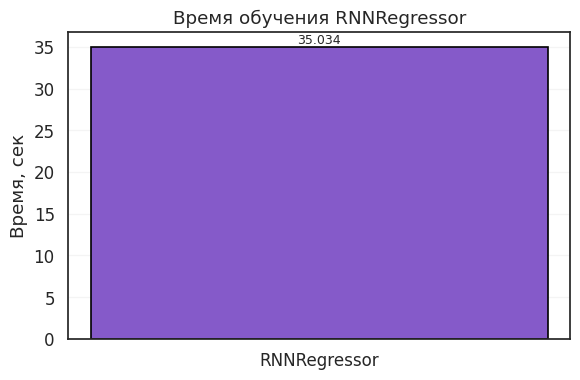

In [ ]:
my_cmap = LinearSegmentedColormap.from_list("my_palette", ["#ffffff", "#9370DB", "#4B0082"])
plt.figure(figsize=(6, 4))
bars = plt.bar(["RNNRegressor"], [train_time],
               color=[my_cmap(0.6)], edgecolor='black', linewidth=1.2)
plt.title("Время обучения RNNRegressor")
plt.ylabel("Время, сек")
plt.grid(axis="y", alpha=0.2)
plt.text(bars[0].get_x() + bars[0].get_width() / 2,
         train_time, f"{train_time:.3f}",
         ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
train_ds     = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

class RNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc  = nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        return self.fc(h_n[-1])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epoch_list = [50, 100, 150]
records = []

for epochs in epoch_list:
    model     = RNNRegressor(input_size=1, hidden_size=64, num_layers=2).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    t0 = time.perf_counter()
    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
    train_time = round(time.perf_counter() - t0, 4)

    model.eval()
    with torch.no_grad():
        pred_tr = model(X_train.to(device)).cpu().numpy()
        pred_te = model(X_test.to(device)).cpu().numpy()

    records.append({
        'Epochs':     epochs,
        'Train_RMSE': np.sqrt(mean_squared_error(y_train.numpy(), pred_tr)),
        'Test_RMSE':  np.sqrt(mean_squared_error(y_test.numpy(),  pred_te)),
        'Train_R2':   r2_score(y_train.numpy(), pred_tr),
        'Test_R2':    r2_score(y_test.numpy(),  pred_te),
        'Train_Time': train_time
    })

df_res = pd.DataFrame(records).set_index('Epochs')
df_res

,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Train_Time
Epochs,,,,,
50,1.017133,1.144789,0.827794,0.782393,34.4070
100,0.805466,1.106042,0.892009,0.796874,68.9871
150,0.674031,1.132408,0.924377,0.787074,103.6394


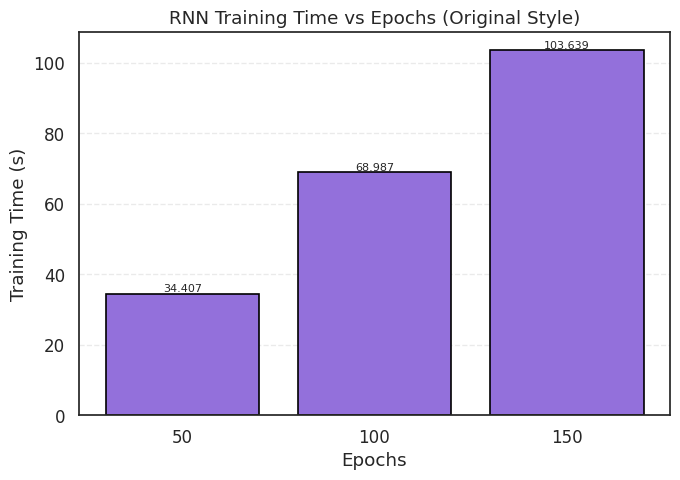

In [ ]:
plt.figure(figsize=(7, 5))
bars = plt.bar(df_res.index.astype(str), df_res['Train_Time'],
               color='#9370DB', edgecolor='black', linewidth=1.2)
plt.title("RNN Training Time vs Epochs (Original Style)")
plt.xlabel("Epochs")
plt.ylabel("Training Time (s)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
for bar, t in zip(bars, df_res['Train_Time']):
    plt.text(bar.get_x() + bar.get_width()/2, t,
             f"{t:.3f}", ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()


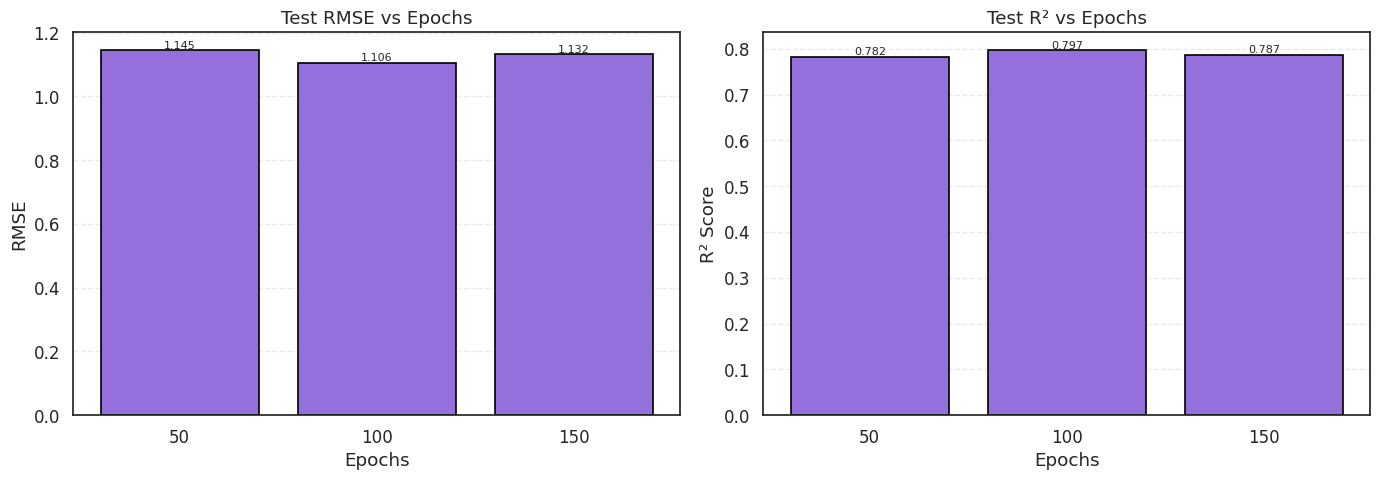

In [ ]:
bar_color = '#9370DB'
edge_color = 'black'
line_width = 1.2
grid_alpha = 0.4
text_fontsize = 8
epochs_labels = df_res.index.astype(str)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes = axes.flatten()
# 1. Test RMSE
ax1 = axes[0]
test_rmse_values = df_res['Test_RMSE']
bars_test_rmse = ax1.bar(epochs_labels, test_rmse_values,
                         color=bar_color, edgecolor=edge_color, linewidth=line_width)
ax1.set_title("Test RMSE vs Epochs")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSE")
ax1.grid(axis="y", linestyle="--", alpha=grid_alpha)
for bar, val in zip(bars_test_rmse, test_rmse_values):
    ax1.text(bar.get_x() + bar.get_width()/2, val,
             f"{val:.3f}", ha='center', va='bottom', fontsize=text_fontsize)

# 2. Test R²
ax2 = axes[1]
test_r2_values = df_res['Test_R2']
bars_test_r2 = ax2.bar(epochs_labels, test_r2_values,
                       color=bar_color, edgecolor=edge_color, linewidth=line_width)
ax2.set_title("Test R² vs Epochs")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("R² Score")
ax2.grid(axis="y", linestyle="--", alpha=grid_alpha)
for bar, val in zip(bars_test_r2, test_r2_values):
    ax2.text(bar.get_x() + bar.get_width()/2, val,
             f"{val:.3f}", ha='center', va='bottom', fontsize=text_fontsize)

plt.tight_layout()
plt.show()

# 8. Выводы:

In [ ]:
final_ordered_df_sorted = final_ordered_df.sort_values(by='RMSE', ascending=False).reset_index(drop=True)
final_ordered_df_sorted

,Model,MAE,MSE,RMSE,R2,MedAE,MSLE,Time
0,SVR (Linear) C = 10,1.575000,3.979000,1.995000,0.339000,1.256000,0.332,82.2694
1,SVR (Linear) C = 1,1.575000,3.979000,1.995000,0.339000,1.256000,0.332,26.0208
2,Lasso Regression,1.687000,3.946000,1.986000,0.345000,1.578000,0.422,0.2527
3,ElasticNet,1.668000,3.875000,1.968000,0.357000,1.579000,0.416,0.0458
4,Ridge Regression,1.623000,3.746000,1.936000,0.378000,1.540000,0.402,0.0219
5,Linear Regression,1.623000,3.746000,1.936000,0.378000,1.540000,0.402,0.0271
6,Bayesian Ridge,1.623000,3.746000,1.935000,0.378000,1.540000,0.402,0.0311
7,Decision Tree,0.978000,2.258000,1.503000,0.625000,0.586000,0.187,0.0416
8,AdaBoost,0.981891,1.879296,1.370874,0.687955,0.676259,NaN,7.5361
9,KNN,0.821000,1.696000,1.302000,0.718000,0.400000,0.155,0.3452


| Группа моделей                           | Лучшая модель из группы                                    | R²        | RMSE      | Время обучения\*         | Вывод                                                                                                                                  |
| :--------------------------------------- | :--------------------------------------------------------- | :-------- | :-------- | :----------------------- | :------------------------------------------------------------------------------------------------------------------------------------- |
| **Базовые** (линейные, KNN, дерево)      | KNN                                                        | 0.718     | 1.302     | 0.3452 с                 | Линейные модели и простое дерево показывают низкое качество (R² ~0.3-0.6); KNN (после масштабирования) лучше, но все еще объясняет < 72% дисперсии. |
| **Бэггинг** (RF, ExtraTrees, Bagging DT) | Extra Trees                                                | 0.738775  | 1.254285  | ≈ 6.7 с                  | Снижение ошибки RMSE примерно на 4-18% против лучшего базового (KNN), но рост ресурсоёмкости; модель всё ещё может быть немного недоучена.  |
| **Градиентный бустинг**                  | LightGBM                                                   | 0.829362  | 1.013740  | ≈ 0.85 с                 | Существенный скачок качества (R² > 0.82) при очень малом времени обучения.                                                              |
| **LightGBM + Optuna**                    | (подобраны параметры)                                      | **0.830** | **0.997** | 120.0 с (включая оптимизацию) | Лучшая точность R² и RMSE на всём эксперименте, но время на подбор параметров значительно.                                              |
| **Stacking (классический)**              | Stacking (classic)                                         | 0.826234  | 1.022990  | 261.4 с                  | Точность сопоставима с одиночным LightGBM, но время обучения значительно выше — может быть неоправданно.                                   |
| **Stacking (только бустинги)**           | Stacking (boostings)                                       | 0.824498  | 1.028089  | 55.9 с                   | Снова результаты хуже или на уровне одного хорошо настроенного LightGBM, но быстрее "классического" стекинга.                            |
| **RNN-регрессор (LSTM)**                 | DeepModel (Epochs=100, Best Test_R2)                       | 0.796874  | 1.106042  | 69.0 с                   | Для данных табличного типа уступает градиентным бустингам и требует больше времени на обучение.                                       |

**Итог:**


Цель курсовой достигнута: проведено поэтапное эмпирическое сравнение 21 модели; показано, что оптимизированный LightGBM минимизирует ошибку (RMSE ≈ 0.997 — в среднем «промах» < 1 балла по 10-балльной шкале) и объясняет ~ 83,5 % дисперсии транспортного трафика, превосходя как бэггинг, так и сложные стэки.

# 9. Источкники:

1. Яндекс Образование. Ансамбли в машинном обучении [Электронный ресурс]. — URL: https://education.yandex.ru/handbook/ml/article/ansambli-v-mashinnom-obuchenii (дата обращения: 25.04.2025).

2. Траск Э. Грокаем глубокое обучение / Э. Траск. — Москва : ДМК Пресс, 2020. — 400 с. — [Электронный ресурс]. — URL: https://publ.lib.ru/ARCHIVES/B/''Biblioteka_programmista''_(seriya)/%D2%F0%E0%F1%EA%20%DD._%20%C3%F0%EE%EA%E0%E5%EC%20%E3%EB%F3%E1%EE%EA%EE%E5%20%EE%E1%F3%F7%E5%ED%E8%E5.(2020).pdf (дата обращения: 01.05.2025).

3. Радченко В. Открытый курс машинного обучения. Тема 5. Композиции: бэггинг, случайный лес [Электронный ресурс] // Хабр. — 27 марта 2017 г. — URL: https://habr.com/ru/companies/ods/articles/324402/ (дата обращения: 15.04.2025).

4. Scikit-learn.ru: неофициальная русскоязычная документация библиотеки scikit-learn [Электронный ресурс]. — URL: https://scikit-learn.ru/ (дата обращения: 01.05.2025).

5. CatBoost: официальная документация [Электронный ресурс]. — URL: https://catboost.ai/docs/en/ (дата обращения: 15.04.2025).

6. XGBoost: Python API Reference [Электронный ресурс]. — URL: https://xgboost.readthedocs.io/en/latest/python/python_api.html (дата обращения: 15.04.2025).

7. LightGBM: документация [Электронный ресурс]. — URL: https://lightgbm.readthedocs.io/en/stable/ (дата обращения: 15.04.2025).

8. Серрано Л. Грокаем машинное обучение / Л. Серрано; пер. с англ. Л. К. Чикина. — Санкт-Петербург : Питер, 2024. — 512 с. — [Электронный ресурс]. — URL: https://www.labirint.ru/books/995275/ (дата обращения: 01.05.2025)
9. Optuna : официальная документация [Электронный ресурс]. — URL: https://optuna.readthedocs.io/en/stable/ (дата обращения: 29.04.2025).

10. PyTorch : официальная документация [Электронный ресурс]. — URL: https://pytorch.org/docs/stable/ (дата обращения: 18.05.2025).